# Trabajo practico: Prediccion de lluvia Australia

Alumnos: Noir Nicolas, González Ignacio

Año: 2024

Materia: Aprendizaje automático 1

Carrera: TUIA

## Librerias

In [22]:
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install plotly
# !pip install optuna
# !pip install shap
# !pip install pycaret[full]
# !pip install optuna-integration[sklearn]
# !pip install tensorflow

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
import plotly.express as px
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn import metrics
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, roc_curve, roc_auc_score, auc , jaccard_score, matthews_corrcoef, mean_squared_error, make_scorer
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from category_encoders import OneHotEncoder
import optuna
import shap
import pycaret
import tensorflow as tf
from pycaret.classification import *
from pandas.core.frame import DataFrame
from pandas.core.frame import Series
# Libreria necesaria para poder ocultar errores que empeoran la visualización del notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None


## Introducción
En este trabajo vamos a crear un modelo de clasificación para la predicción de la lluvia al día siguiente en Australia en 10 ciudades elegidas al azar.

Para esto necesitaremos hacer ciertos análisis, escalados, imputados, etc., los cuales vamos a presentar brevemente a continuación (en el código va a ser explicado y justificado):

Primero necesitamos importar el dataset. Como este tiene más de 10 ciudades de Australia, haremos una selección al azar con sample y reduciremos el dataset a los datos que sean de esas ciudades. El siguiente paso es dropear todos los registros que tengan un valor faltante en la variable explicativa, después chequearemos y eliminaremos filas duplicadas. Una vez hecho esta pequeña limpieza inicial, dividimos el dataset en train y test, siendo 80/20 la proporción. También tendremos que dividirlo de manera que en el punto donde se divida para atrás en fecha sea entrenamiento y para adelante sea prueba. A continuación analizaremos los valores faltantes de x_train, decidiendo qué filas son dropeadas por la cantidad de valores faltantes. Lo siguiente es el análisis de las distribuciones, correlaciones, tipos de datos, outliers, medias, medianas, etc.
Después codificamos las variables categóricas y cíclicas para poder imputar valores faltantes mediante MICE con LinearRegression o Interpolación. Una vez imputados los valores faltantes, corregimos los valores erróneos, que pueden ser valores negativos o fuera de la escala/rango o fuera de su tipo de dato. Por ejemplo, en el caso de Rainfall no puede haber lluvia negativa. El siguiente paso es decodificar las variables Location y las direcciones del viento, ya que fueron codificadas con ordinal encoder para su posible uso en la imputación. Ahora es necesario devolverlos a su forma original y codificarlos de nuevo para que sean utilizables en la regresión logística. Pasamos a la creación de los modelos de clasificación, donde haremos 4 modelos de clasificación. Uno por cada tipo de método de imputación y a su vez uno por cada valor del parámetro de class_weight de LogisticRegression que puede ser balanced donde imita un balanceo del dataset o default en el que se usa la regresión logística con los datos que tenemos, aunque estén desbalanceados. Calculamos todas las métricas de clasificación y la que vamos a elegir para comparar los modelos va a ser el recall.

## Código

### Funciones

In [24]:
def funciones_roc(y_true: Series, y_prob1: Series, nombre_1: str, y_prob2: Series=None, nombre_2: str=None) -> None:
    """
    Grafica la curva ROC de uno o dos modelos.

    Parameters
    ----------
    y_true: Series
        Variable target del dataset.
    y_prob1: Series
        Probabilidades de predecir la clase verdadera de cada dato del primer modelo.
    nombre_1: str
        Nombre del primer modelo
    y_prob2: Series
        Probabilidades de predecir la clase verdadera de cada dato del segundo modelo
    nombre_2: str
        Nombre del segundo modelo
    
    """
    
    if y_prob2 is None:
        fpr_relog, tpr_relog, thresholds_relog = roc_curve(y_true, y_prob1)
        roc_auc_relog = auc(fpr_relog, tpr_relog)

        optimal_idx_relog = np.argmax(tpr_relog - fpr_relog)
        best_thresh_relog = thresholds_relog[optimal_idx_relog]
        best_fpr_relog = fpr_relog[optimal_idx_relog]
        best_tpr_relog = tpr_relog[optimal_idx_relog]

        plt.plot(fpr_relog, tpr_relog, color='darkorange', lw=2, label=f'{nombre_1} (AUC = %0.4f)' % roc_auc_relog)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.scatter(best_fpr_relog, best_tpr_relog, color='red', label=f'índice de Younden (Threshold = {best_thresh_relog:.4f})')
        plt.text(best_fpr_relog, best_tpr_relog, f'({best_fpr_relog:.2f}, {best_tpr_relog:.2f})', color='red', ha='right')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos (FPR)')
        plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
        plt.title(f'Curva ROC - {nombre_1}')
        plt.legend(loc="lower right")
    else:
        fpr_relog, tpr_relog, thresholds_relog = roc_curve(y_true, y_prob1)
        roc_auc_relog = auc(fpr_relog, tpr_relog)

        # Curva ROC para el modelo desbalanceado
        fpr_relog_desba, tpr_relog_desba, thresholds_relog_desba = roc_curve(y_true, y_prob2)
        roc_auc_relog_desba = auc(fpr_relog_desba, tpr_relog_desba)

        optimal_idx_relog = np.argmax(tpr_relog - fpr_relog)
        best_thresh_relog = thresholds_relog[optimal_idx_relog]
        best_fpr_relog = fpr_relog[optimal_idx_relog]
        best_tpr_relog = tpr_relog[optimal_idx_relog]

        optimal_idx_relog_desba = np.argmax(tpr_relog_desba - fpr_relog_desba)
        best_thresh_desba = thresholds_relog_desba[optimal_idx_relog_desba]
        best_fpr_relog_desba = fpr_relog_desba[optimal_idx_relog_desba]
        best_tpr_relog_desba = tpr_relog_desba[optimal_idx_relog_desba]

        # Crear la figura con 2 subplots (1 fila, 2 columnas)
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Gráfico para el modelo balanceado
        axes[0].plot(fpr_relog, tpr_relog, color='darkorange', lw=2, label=f'{nombre_1} (AUC = %0.4f)' % roc_auc_relog)
        axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0].scatter(best_fpr_relog, best_tpr_relog, color='red', label=f'índice de Younden (Threshold = {best_thresh_relog:.4f})')
        axes[0].text(best_fpr_relog, best_tpr_relog, f'({best_fpr_relog:.2f}, {best_tpr_relog:.2f})', color='red', ha='right')
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('Tasa de Falsos Positivos (FPR)')
        axes[0].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
        axes[0].set_title(f'Curva ROC - {nombre_1}')
        axes[0].legend(loc="lower right")

        # Gráfico para el modelo desbalanceado
        axes[1].plot(fpr_relog_desba, tpr_relog_desba, color='green', lw=2, label=f'{nombre_2} (AUC = %0.4f)' % roc_auc_relog_desba)
        axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[1].scatter(best_fpr_relog_desba, best_tpr_relog_desba, color='red', label=f'índice de Younden (Threshold = {best_thresh_desba:.4f})')
        axes[1].text(best_fpr_relog_desba, best_tpr_relog_desba, f'({best_fpr_relog_desba:.2f}, {best_tpr_relog_desba:.2f})', color='red', ha='right')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
        axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
        axes[1].set_title(f'Curva ROC - {nombre_2}')
        axes[1].legend(loc="lower right")

        plt.tight_layout()
        plt.show()

In [25]:
def metrica_recalls(recall_clase0: float, recall_clase1: float) -> float:
    """
    Calcula el Wrecall de un modelo.
    """
    metrica = 2 * ((recall_clase0*recall_clase1) / (recall_clase0+recall_clase1))
    return metrica

In [26]:
def calcular_wrecall_estimador(y_true: Series, y_pred: Series, **kwargs) -> float:
    """
    
    """
    recall_llueve = recall_score(y_true, y_pred, pos_label=1)
    recall_no_llueve = recall_score(y_true, y_pred, pos_label=0)
    wrecall = metrica_recalls(recall_no_llueve, recall_llueve)
    return wrecall

In [27]:
def calcular_metricas_modelo(y_true: Series, y_pred: Series, nombre_modelo: str) -> DataFrame:
    """
    Clacula las metricas de Accuaracy, Precision, Recall, F1, Matthews, Jaccard y Wrecall, para los casos de lluvia y los de no lluvia.
    Las devuelve en un formato de DataFrame
    """
    
    metricas_llueve = {
    'Accuracy': accuracy_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred, pos_label=1),
    'Recall': recall_score(y_true, y_pred, pos_label=1),
    'F1': f1_score(y_true, y_pred, pos_label=1),
    'Matthews': matthews_corrcoef(y_true, y_pred),
    'Jaccard': jaccard_score(y_true, y_pred),
    'Wrecall': calcular_wrecall_estimador(y_true, y_pred)

    }

    metricas_no_llueve = {
    'Accuracy': accuracy_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred, pos_label=0),
    'Recall': recall_score(y_true, y_pred, pos_label=0),
    'F1': f1_score(y_true, y_pred, pos_label=0),
    'Matthews': matthews_corrcoef(y_true, y_pred),
    'Jaccard': jaccard_score(y_true, y_pred),
    'Wrecall': calcular_wrecall_estimador(y_true, y_pred)
    }
    metricas_comparadas = pd.DataFrame([metricas_llueve,metricas_no_llueve], index=[f'{nombre_modelo} - Llueve',f'{nombre_modelo} - No Llueve'])

    return metricas_comparadas

In [28]:
def positivisar(df: DataFrame):

    columnas = df.columns
    for col in columnas:
        if col in ['RainToday_Yes', 'Location', 'week_year','WindGustDir', 'WindDir9am', 'WindDir3pm']:
            continue
        df[col][df[col] < 0] = 0
        df[col][df[col] > 1] = 1
    return df

In [29]:
def merge_var(df: DataFrame, df2: DataFrame)-> DataFrame:
    """
    Junta dos dataframes, uno con Location, WindGustDir, WindDir9am y WindDir3pm codificados, y al otro dataset se les sacan estas variables para unirlos.
    """
    x_train_merge_imp = pd.merge(df, df2,left_index=True, right_index=True, how='left')
    return x_train_merge_imp

In [30]:
def codificar_variables(dataset: DataFrame) -> DataFrame:
    """
    Codifica y reemplaza date, WindGustDir, WindDir9am, WindDir3pm, Raintoday, Location
    """
    
    dataset['sin_week'] = np.sin(2 * np.pi * dataset['week_year'] / 52)
    dataset['cos_week'] = np.cos(2 * np.pi * dataset['week_year'] / 52)
    dataset.drop('week_year', axis=1, inplace=True)

    puntos_cardinales = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W','NW']

    angulos = np.arange(0, 360, 45)
    df_angulos_cardinal = pd.DataFrame({'puntos': puntos_cardinales, 'angulos': angulos})
    
    dataset_ang = dataset.merge(df_angulos_cardinal, left_on='WindGustDir', right_on=['puntos'], how='left')
    dataset_ang = dataset.merge(df_angulos_cardinal, left_on='WindDir9am', right_on=['puntos'], how='left')
    dataset_ang = dataset.merge(df_angulos_cardinal, left_on='WindDir3pm', right_on=['puntos'], how='left')

    dataset_ang['sin_WindGustDir'] = round(np.sin(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)
    dataset_ang['cos_WindGustDir'] = round(np.cos(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)

    dataset_ang['sin_WindDir9am'] = round(np.sin(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)
    dataset_ang['cos_WindDir9am'] = round(np.cos(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)

    dataset_ang['sin_WindDir3pm'] = round(np.sin(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)
    dataset_ang['cos_WindDir3pm'] = round(np.cos(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)

        
    dataset_ang.drop('WindGustDir', axis=1, inplace=True)
    dataset_ang.drop('WindDir9am', axis=1, inplace=True)
    dataset_ang.drop('WindDir3pm', axis=1, inplace=True)

    dataset_ang.drop('angulos', axis=1, inplace=True)
    dataset_ang.drop('puntos', axis=1, inplace=True)
    
    dataset_codificado = pd.get_dummies(dataset_ang, columns=['Location'], drop_first=True)
    dataset_codificado['RainToday_Yes'] = dataset_codificado['RainToday_Yes'].astype(int)
    return dataset_codificado

### Análisis descriptivo

In [31]:
dataset_lluvia_completo_raw = pd.read_csv('https://raw.githubusercontent.com/nacho-gonz/AA1-Archivos-2024/master/weatherAUS.csv')
ciudades_elegidas = dataset_lluvia_completo_raw["Location"].sample(10, random_state=528548).to_list()
df_ciudad = dataset_lluvia_completo_raw[dataset_lluvia_completo_raw["Location"].isin(ciudades_elegidas)]
df_ciudad.dropna(subset=['RainTomorrow'], inplace=True)

df_ciudad_ord = df_ciudad.sort_values(by='Date')

Importamos el dataset y elegimos 10 ciudades la azar, dropeamos todas las filas que tengan valores faltantes en la variable target y ordenamos el dataset. Esto para que no haya fuga de datos entre train y test, ya que al ser una serie de tiempo necesito que todos los días del conjunto de test no esten mezclados en train.

In [32]:
x_train, x_test, y_train, y_test = train_test_split(df_ciudad_ord.drop("RainTomorrow", axis=1), df_ciudad_ord['RainTomorrow'].values.reshape(-1,1), shuffle=False, test_size=0.2, random_state=28869)

In [33]:
x_train_automl = x_train.copy()
y_train_automl = y_train.copy()
x_test_automl = x_test.copy()
y_test_automl = y_test.copy()


In [34]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((23095, 22), (5774, 22), (23095, 1), (5774, 1))

In [35]:
valores_faltantes = x_train[x_train.isna().any(axis=1)]
valores_faltantes.shape

(11697, 22)

Vemos que hay muchas filas con valores faltantes, el 50% de los datos, esto descarta la posibilidad de dropear todas las filas con valores faltantes, ya que supera el 5% de los datos. Además en una serie de tiempo es necesario tener un análisis más profundo de estos datos faltantes, ya que podría estar sesgando mi modelo por no poder descubrir patrones al quitar estos valores faltantes.

In [36]:
valores_faltantes.isna().sum(axis=0)

Date                0
Location            0
MinTemp           252
MaxTemp           148
Rainfall          238
Evaporation      9876
Sunshine         8173
WindGustDir      2995
WindGustSpeed    2978
WindDir9am       2185
WindDir3pm       1070
WindSpeed9am      465
WindSpeed3pm      632
Humidity9am       255
Humidity3pm       385
Pressure9am      5028
Pressure3pm      5033
Cloud9am         5292
Cloud3pm         5882
Temp9am           173
Temp3pm           343
RainToday         238
dtype: int64

Vemos cuales son las columnas con mayor cantidad de datos faltantes (Evaporation, Sunshine, Cloud3pm, Cloud9am), menor cantidad valores faltantes (RainFall, RainToday, Temp) y ausencia de valores faltantes (Date, Location). 

In [37]:
valores_faltantes.isna().sum(axis=1).value_counts(sort=True)

6     3321
1     2451
4     1614
2     1277
3     1077
7      813
11     315
8      293
5      183
12     177
9       39
17      37
18      28
13      28
10      15
19      10
14      10
15       4
20       4
16       1
Name: count, dtype: int64

Observamos la cantidad de filas que tienen diferentes cantidad de valores faltantes. 

In [38]:
x_train_graficos = x_train.copy()

In [39]:
x_train['Date'] = pd.to_datetime(x_train['Date'])
x_train['week_year'] = x_train['Date'].dt.strftime('%U')

x_test['Date'] = pd.to_datetime(x_test['Date'])
x_test['week_year'] = x_test['Date'].dt.strftime('%U')

x_train['Cloud9am'].replace(to_replace={9:8}, inplace=True)
x_test['Cloud9am'].replace(to_replace={9:8}, inplace=True)

x_train.index = x_train['Date']
x_test.index = x_test['Date']

x_train.drop('Date', axis=1, inplace=True)
x_test.drop('Date', axis=1, inplace=True)

puntos_8 = {'NNE': 'NE', 'ENE': 'E', 'ESE': 'SE', 'SSE':'S', 'SSW': 'SW', 'WSW': 'W', 'WNW': 'NW', 'NNW': 'N'}

x_train['WindGustDir'] = x_train['WindGustDir'].replace(puntos_8)
x_train['WindDir9am'] = x_train['WindDir9am'].replace(puntos_8)
x_train['WindDir3pm'] = x_train['WindDir3pm'].replace(puntos_8)

x_test['WindGustDir'] = x_test['WindGustDir'].replace(puntos_8)
x_test['WindDir9am'] = x_test['WindDir9am'].replace(puntos_8)
x_test['WindDir3pm'] = x_test['WindDir3pm'].replace(puntos_8)

Codificamos la fecha en semanas, corregimos la variable Cloud porque se observaron valores fuera de rango, siendo la nubosidad medida en octetos y siendo que este valor supera esta rango y codificamos Localidad, WindGustDir, WinDir9am, WinDir3pm con un codificador ordinal, ya que nuestro objetivo es codificarlo con 2 variables de seno y coseno lo que no puede ser imputado. 

Reemplazamos los puntos cardinales de las columnas WindGustDir, WindDir9am y WindDir3pm, que son 16, por los 8 puntos cardinales principales, rotando todos los ejes en sentido horario, pasando NNE a NE, de ENE a E, y así sucesivamente, para ambos conjuntos de datos (train y test)

In [40]:
x_train_compl = x_train_graficos.copy()
x_train_compl['RainTomorrow'] = y_train.flatten()

y_train_modif = x_train_compl['RainTomorrow']
x_train_modif = x_train_compl.drop(columns='RainTomorrow')
y_train_codif = pd.get_dummies(y_train_modif, drop_first=True)
y_test_codif = pd.get_dummies(y_test.flatten(), drop_first=True)

In [41]:
x_train_time = x_train.groupby(by=['week_year']).mean(numeric_only=True).reset_index()

In [42]:
x_train_modif.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23095 entries, 45587 to 17530
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           23095 non-null  object 
 1   Location       23095 non-null  object 
 2   MinTemp        22843 non-null  float64
 3   MaxTemp        22947 non-null  float64
 4   Rainfall       22857 non-null  float64
 5   Evaporation    13219 non-null  float64
 6   Sunshine       14922 non-null  float64
 7   WindGustDir    20100 non-null  object 
 8   WindGustSpeed  20117 non-null  float64
 9   WindDir9am     20910 non-null  object 
 10  WindDir3pm     22025 non-null  object 
 11  WindSpeed9am   22630 non-null  float64
 12  WindSpeed3pm   22463 non-null  float64
 13  Humidity9am    22840 non-null  float64
 14  Humidity3pm    22710 non-null  float64
 15  Pressure9am    18067 non-null  float64
 16  Pressure3pm    18062 non-null  float64
 17  Cloud9am       17803 non-null  float64
 18  Cloud3p

In [43]:
print(x_train_modif.groupby('Location').describe().transpose().to_string())

Location                Brisbane     Canberra        Moree    Newcastle         Nhil    Nuriootpa   PearceRAAF        Perth         Sale   SalmonGums
MinTemp       count  2580.000000  2829.000000  2290.000000  2186.000000   985.000000  2409.000000  2166.000000  2608.000000  2420.000000  2370.000000
              mean     16.108333     6.591622    12.407467    13.422049     8.497868     9.246866    12.392198    12.834164     8.332479     9.276287
              std       4.635506     6.233339     6.786552     5.000512     4.958333     5.048927     5.305517     5.131978     4.900524     5.483400
              min       2.600000    -8.000000    -3.300000     2.200000    -2.300000    -3.500000    -1.900000    -0.600000    -3.900000    -4.400000
              25%      12.500000     1.600000     6.600000     9.400000     5.000000     5.800000     8.700000     9.100000     4.700000     5.300000
              50%      16.400000     6.700000    13.000000    13.500000     8.000000     8.900000   

Se observa que la distribución de las variables según la localidad no es significativamente notable.

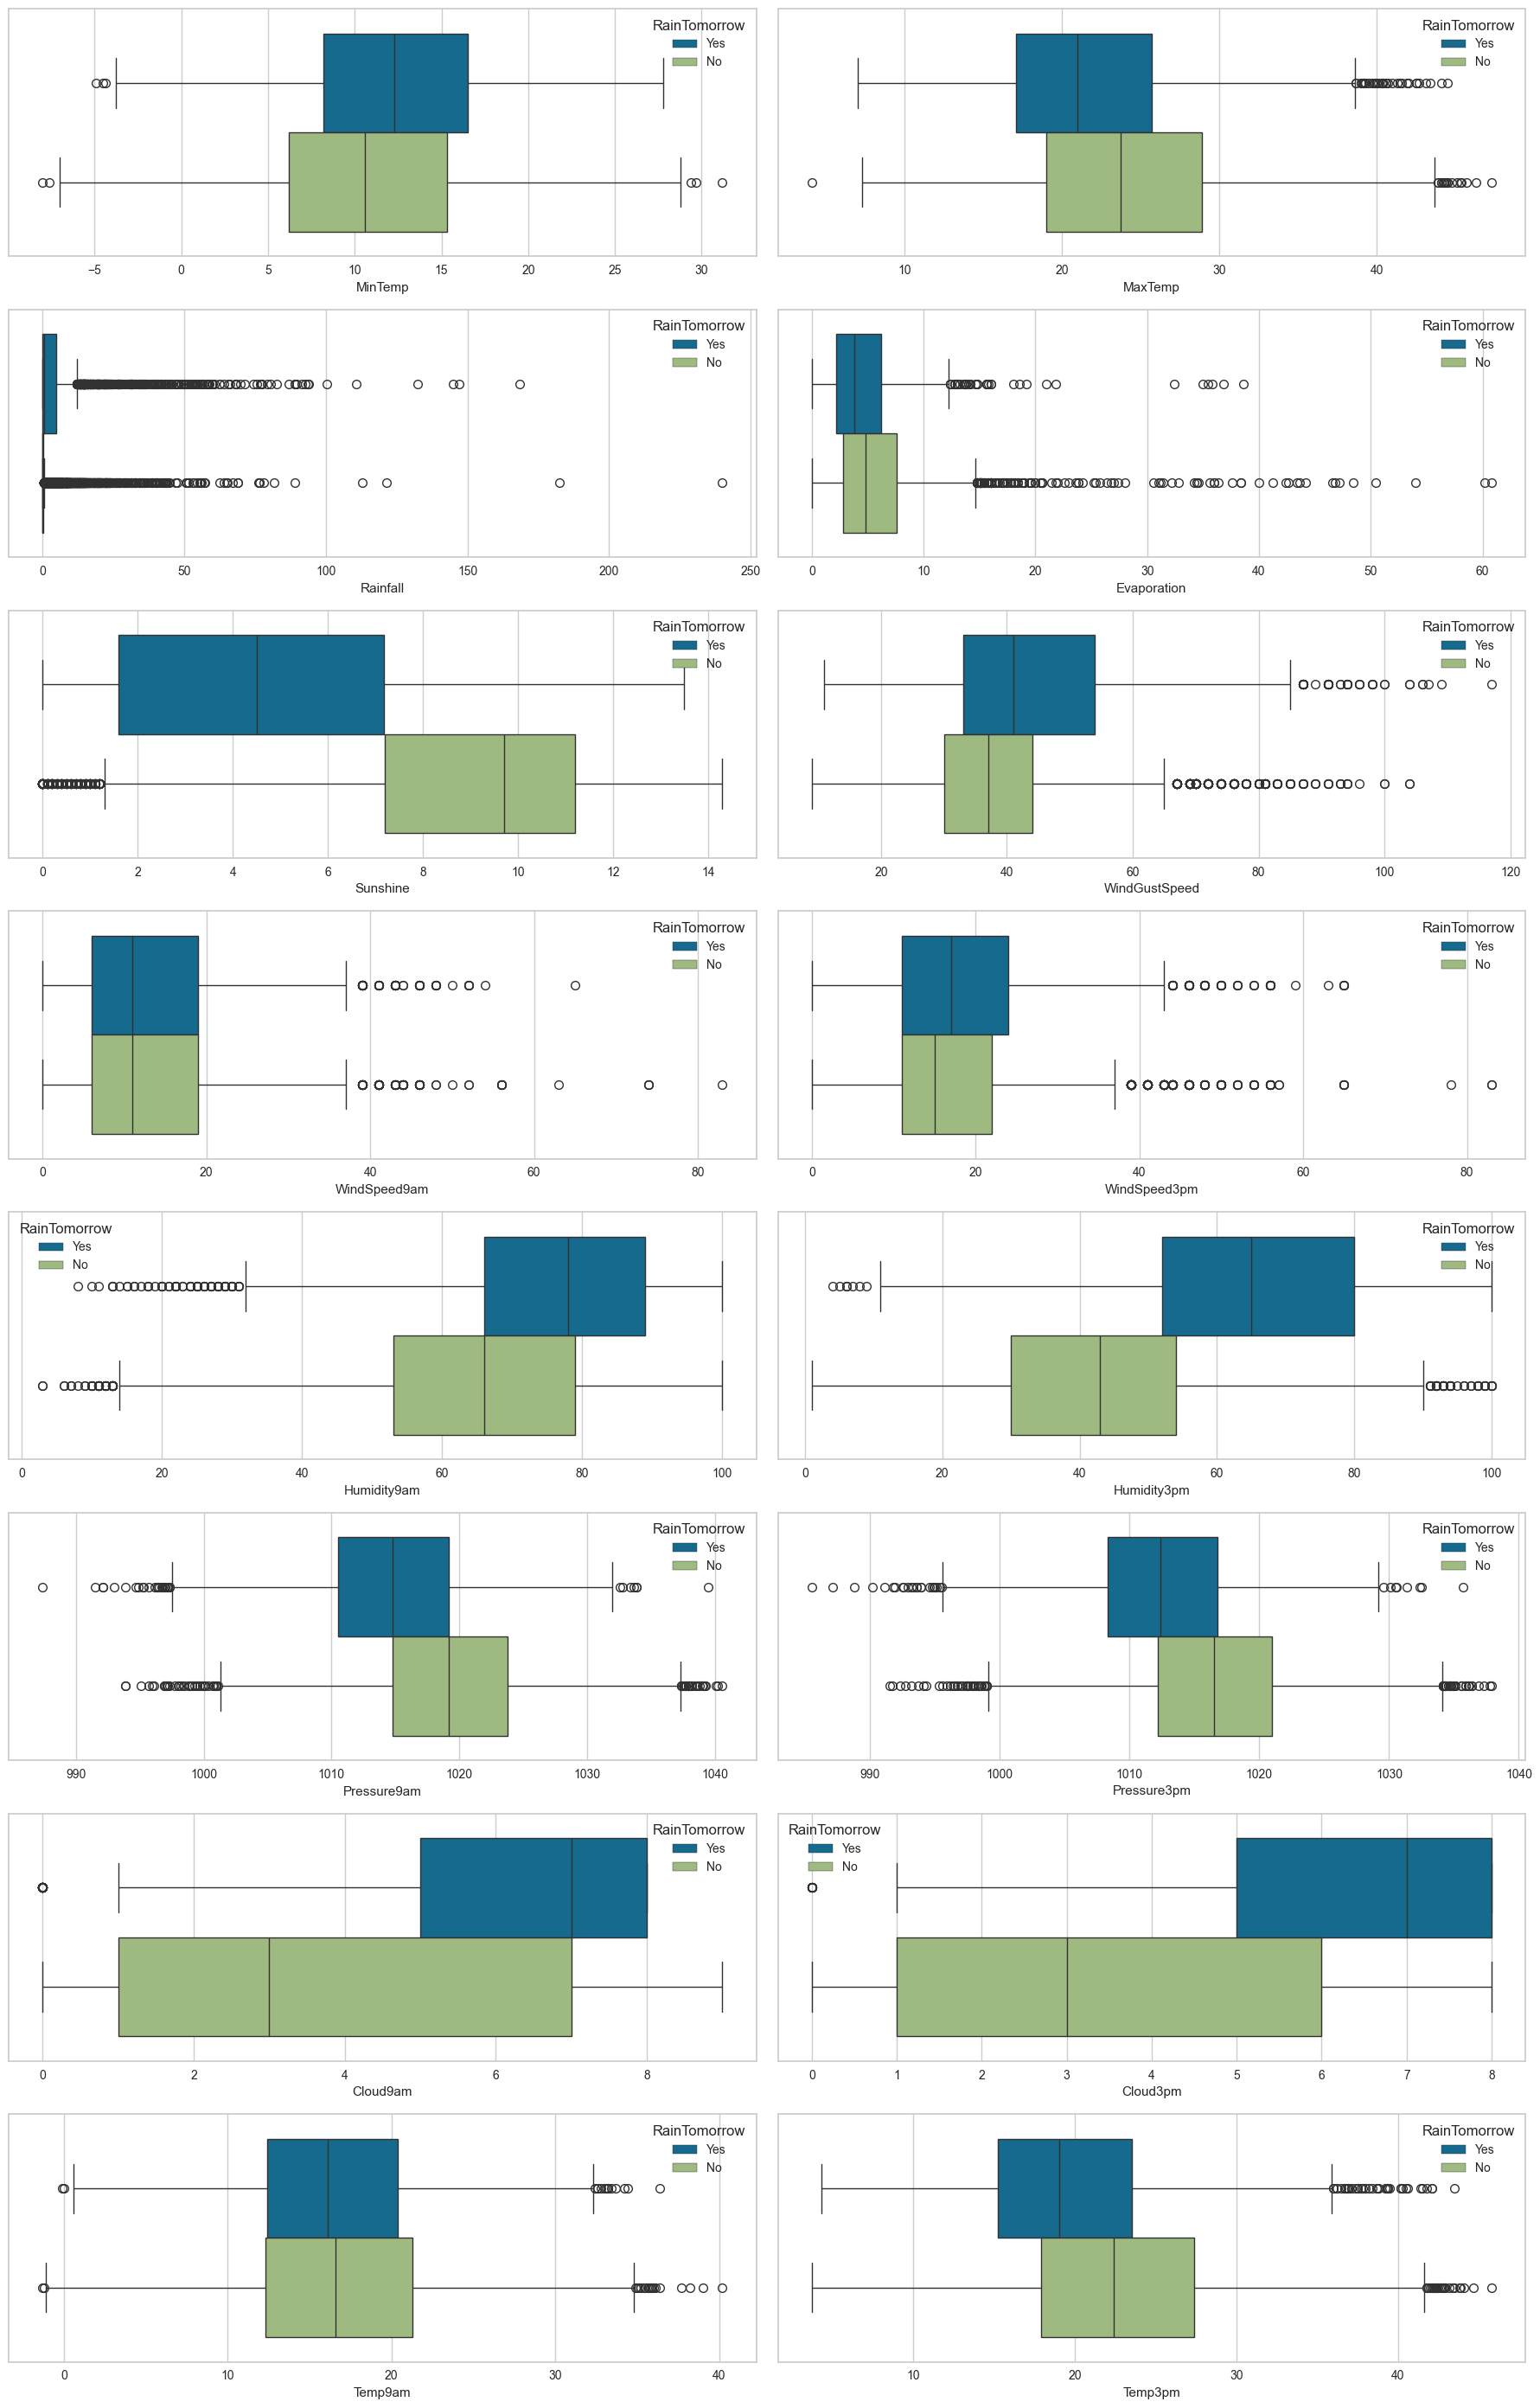

In [44]:
graficar_valores = x_train_compl[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
      'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
      'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
      'Temp3pm','RainTomorrow']]

fig, axes = plt.subplots(8,2)

for name, ax in zip(graficar_valores, axes.flatten()):
      sns.boxplot(x=name, data=graficar_valores, orient='h', ax=ax, hue='RainTomorrow')

fig.set_size_inches(18,28)
plt.tight_layout()
plt.show()

Observamos que variables como Pressure (3pm y 9am), Humidity (3pm y 9am), Sunshine, Cloud (3pm y 9am) tienen una diferencia notable en las distribuciones dependiendo de si llueve o no al día siguiente, dandonos una idea de que pueden ser importantes para la predicción de la target

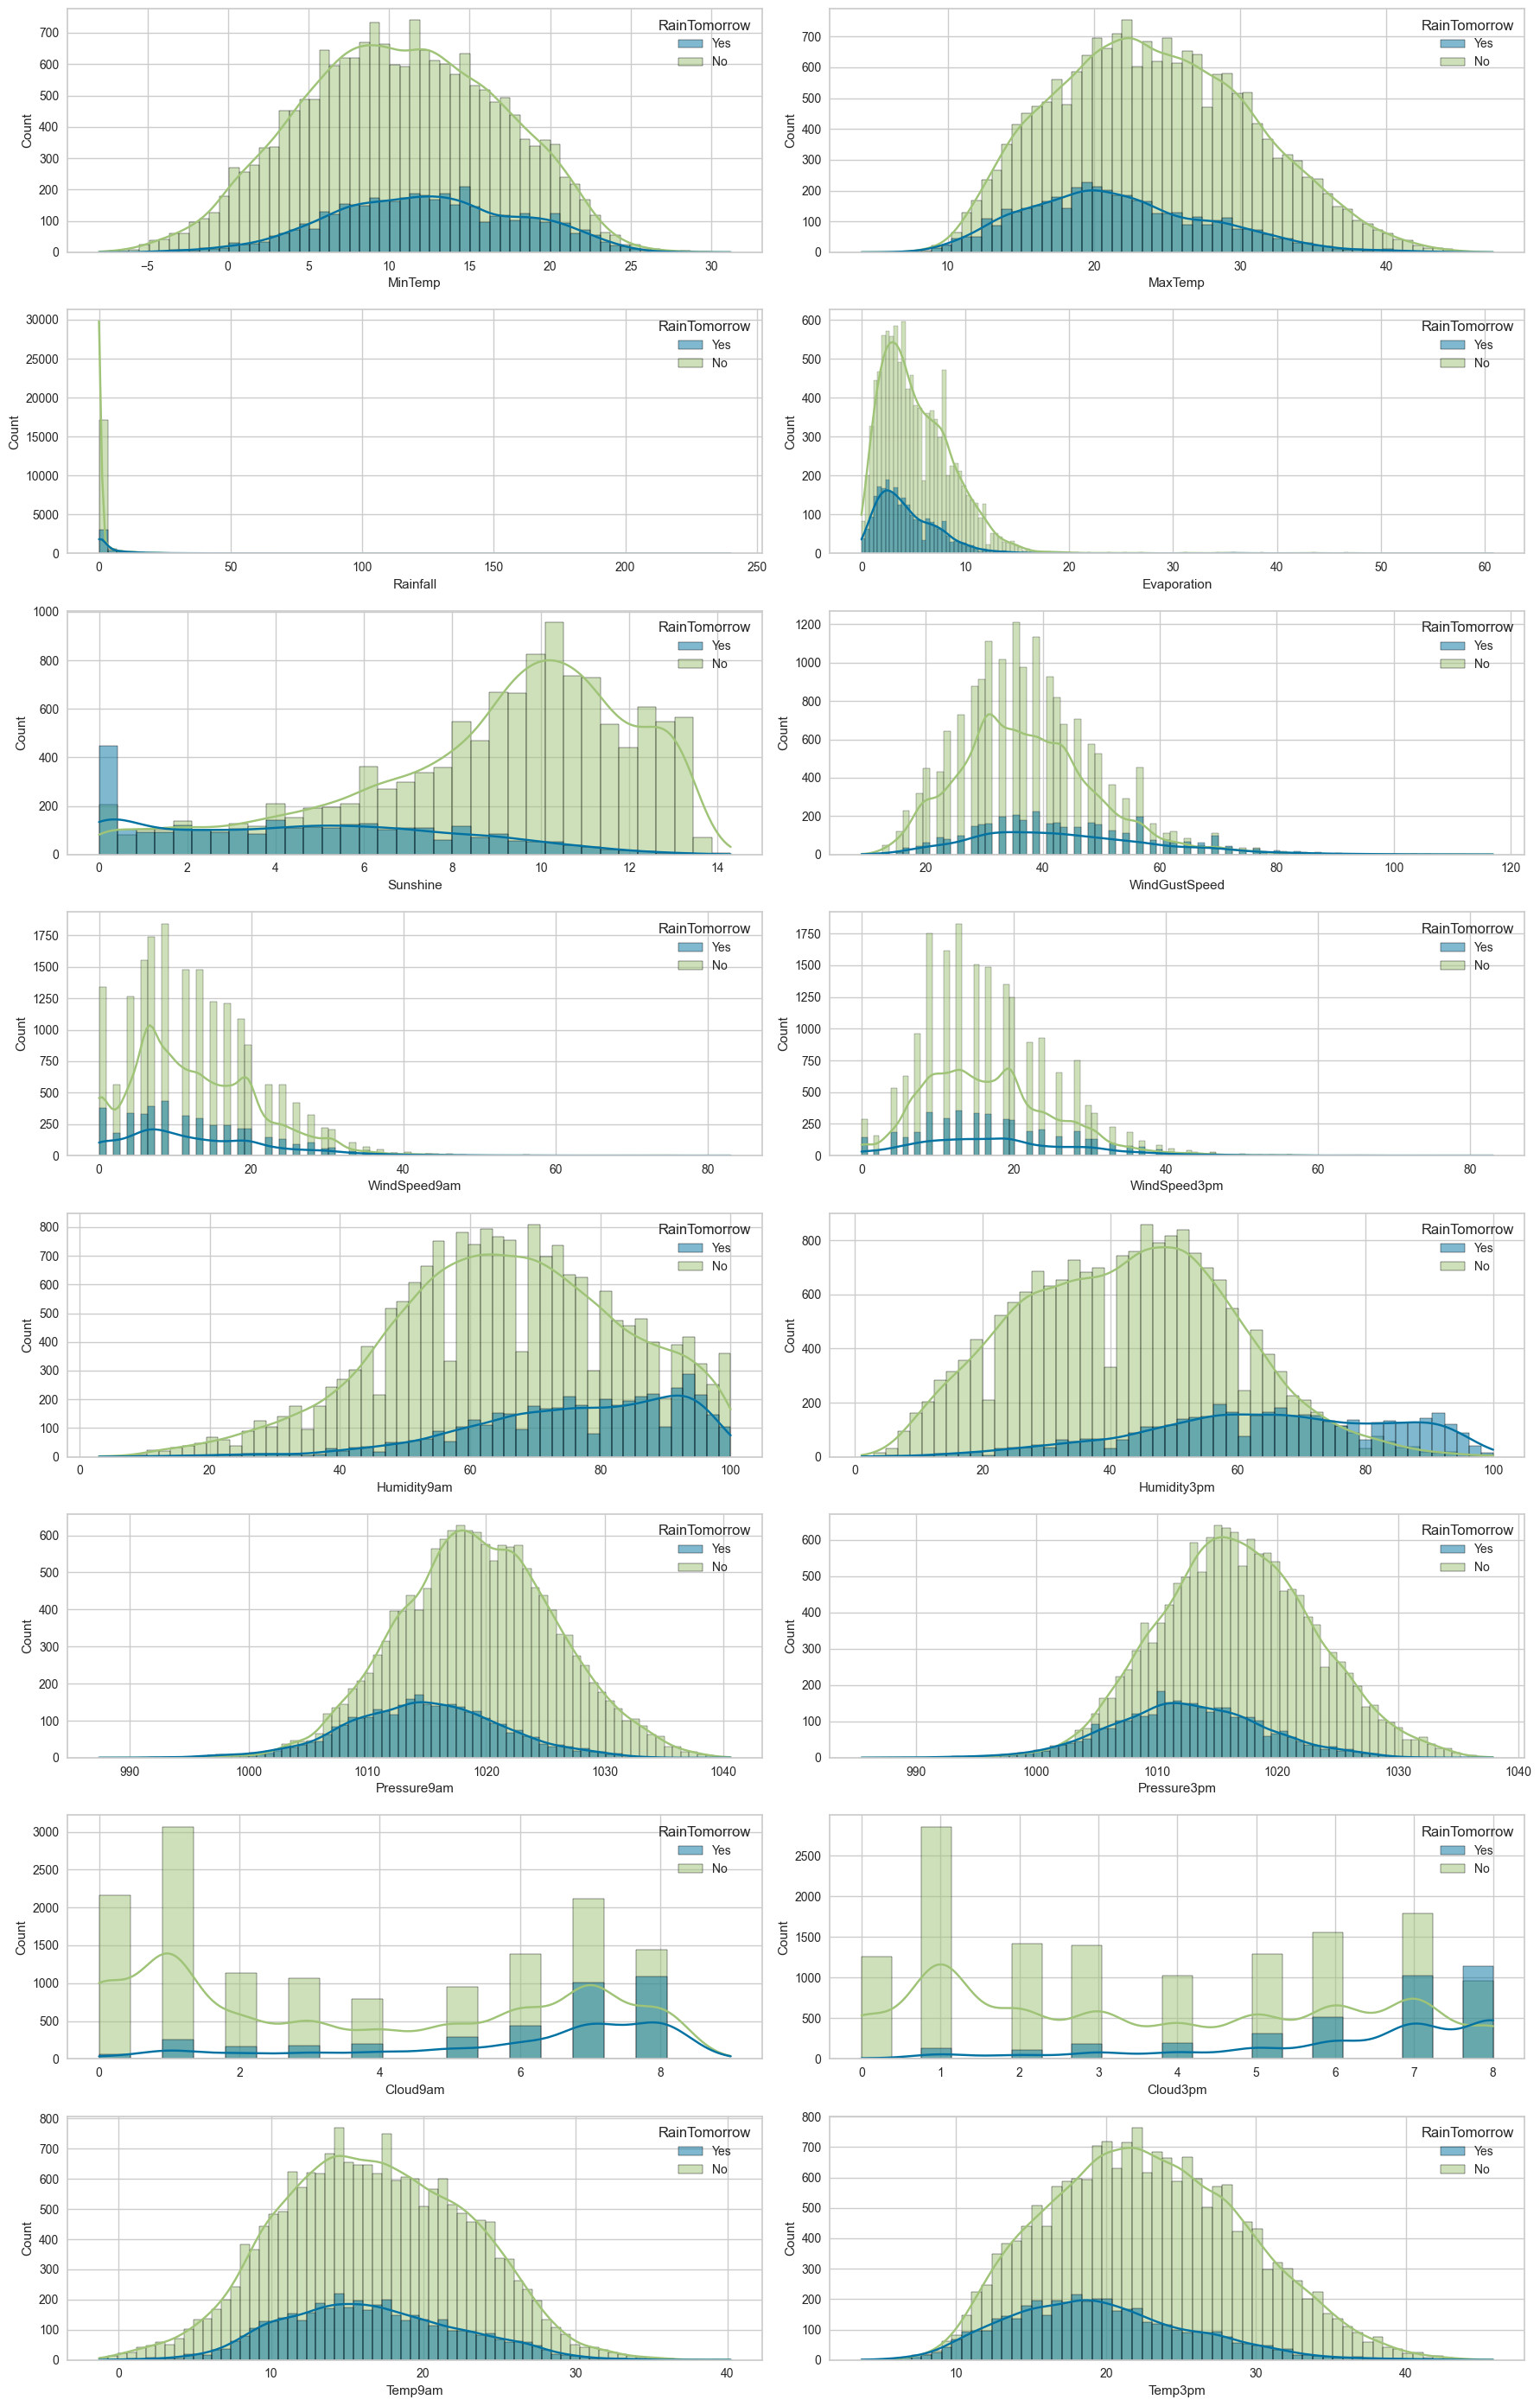

In [45]:
fig2, axes2 = plt.subplots(8,2)

for name, ax in zip(graficar_valores, axes2.flatten()):
    if name == "Rainfall":
        sns.histplot(x=name, data=graficar_valores, ax=ax,kde=True, bins=70, hue='RainTomorrow')
    else:
        sns.histplot(x=name, data=graficar_valores, ax=ax,kde=True, hue='RainTomorrow')

fig2.set_size_inches(18,28)
plt.tight_layout()
plt.show()

Se observa la diferencia entre la cantidad de la target, también en algunas distribuciones se observan diferentes modas como puede ser en Cloud (9am y 3pm) y Sunshine. Dandonos una idea de que podrían ser importantes a la hora de la predicción.

In [46]:
# sns.pairplot(graficar_valores, hue='RainTomorrow', corner=True)
# plt.show()

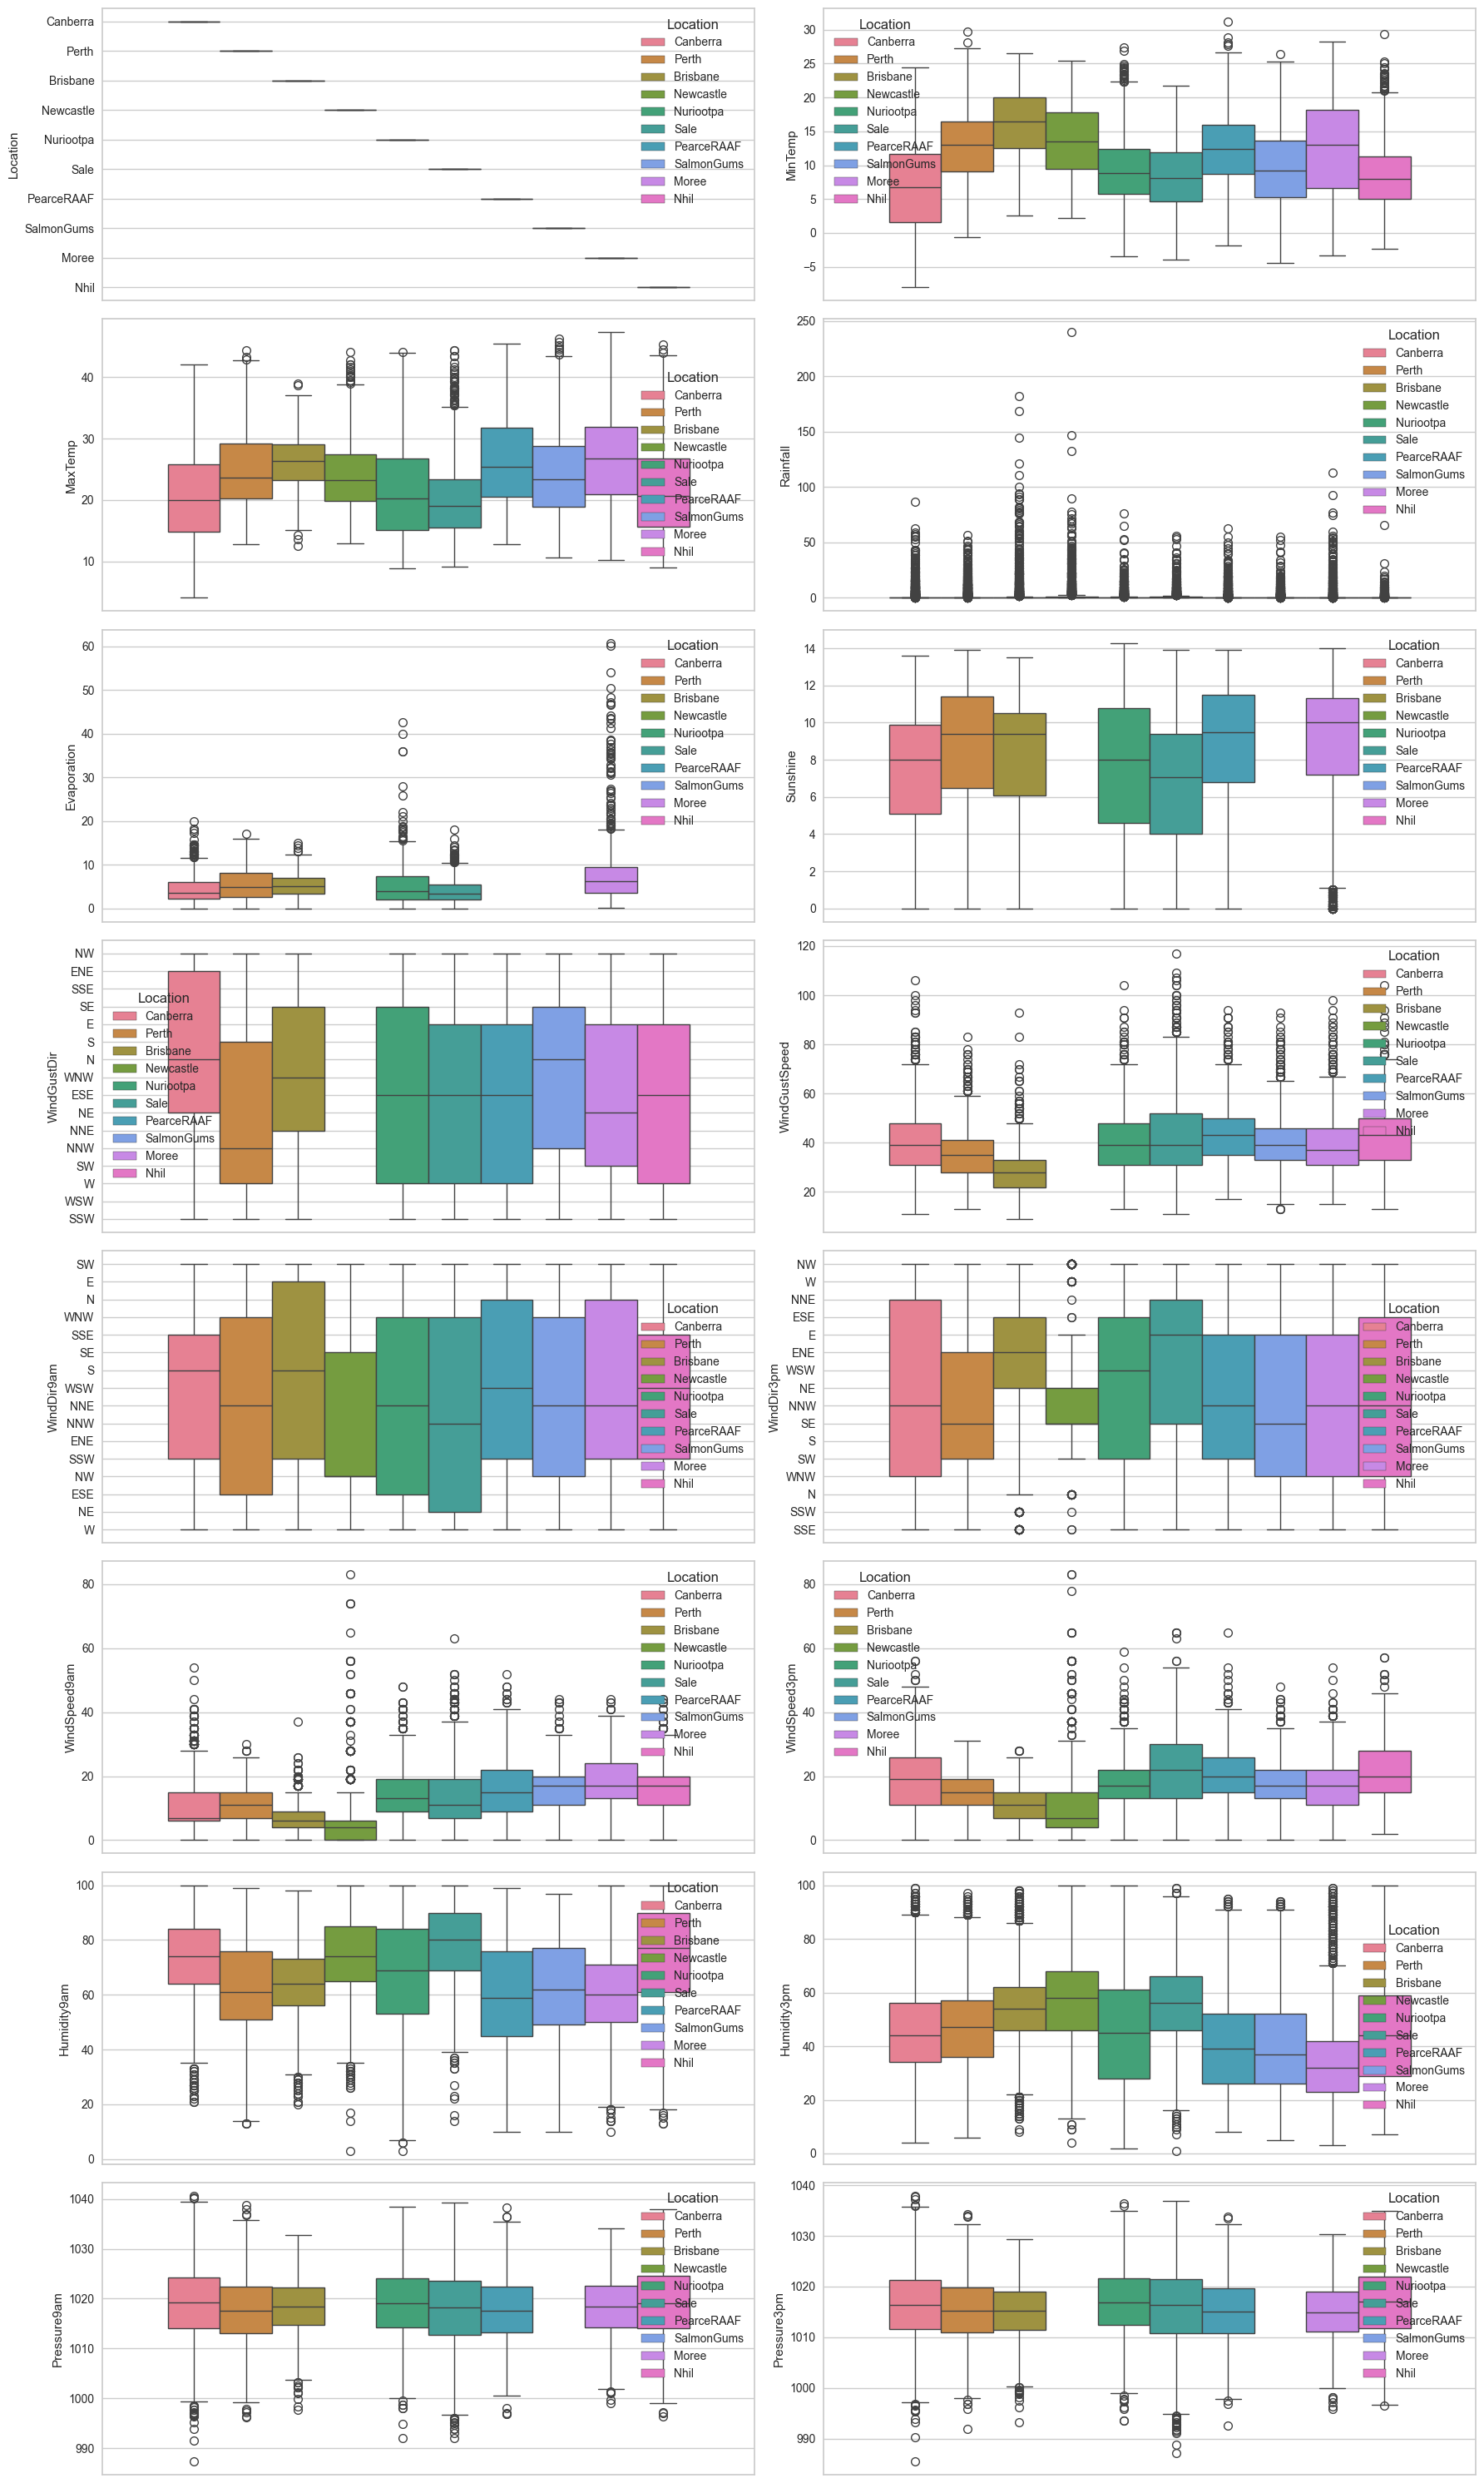

In [47]:
localidades = x_train_modif[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
    'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
    'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
    'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
    'Temp3pm', 'RainToday']]

fig, axes = plt.subplots(8,2)

for name, ax in zip(localidades, axes.flatten()):
    sns.boxplot(y=name, data=localidades, orient='v', ax=ax, hue='Location')

fig.set_size_inches(18,30)
plt.tight_layout()
plt.show()
    

Se puede observar que en la mayoría de las variables el rango de la distribución es muy parecido. Concluyendo de que capaz no sea necesario hacer una imputación tomando en cuenta de que ciudad proviene el valor faltante.

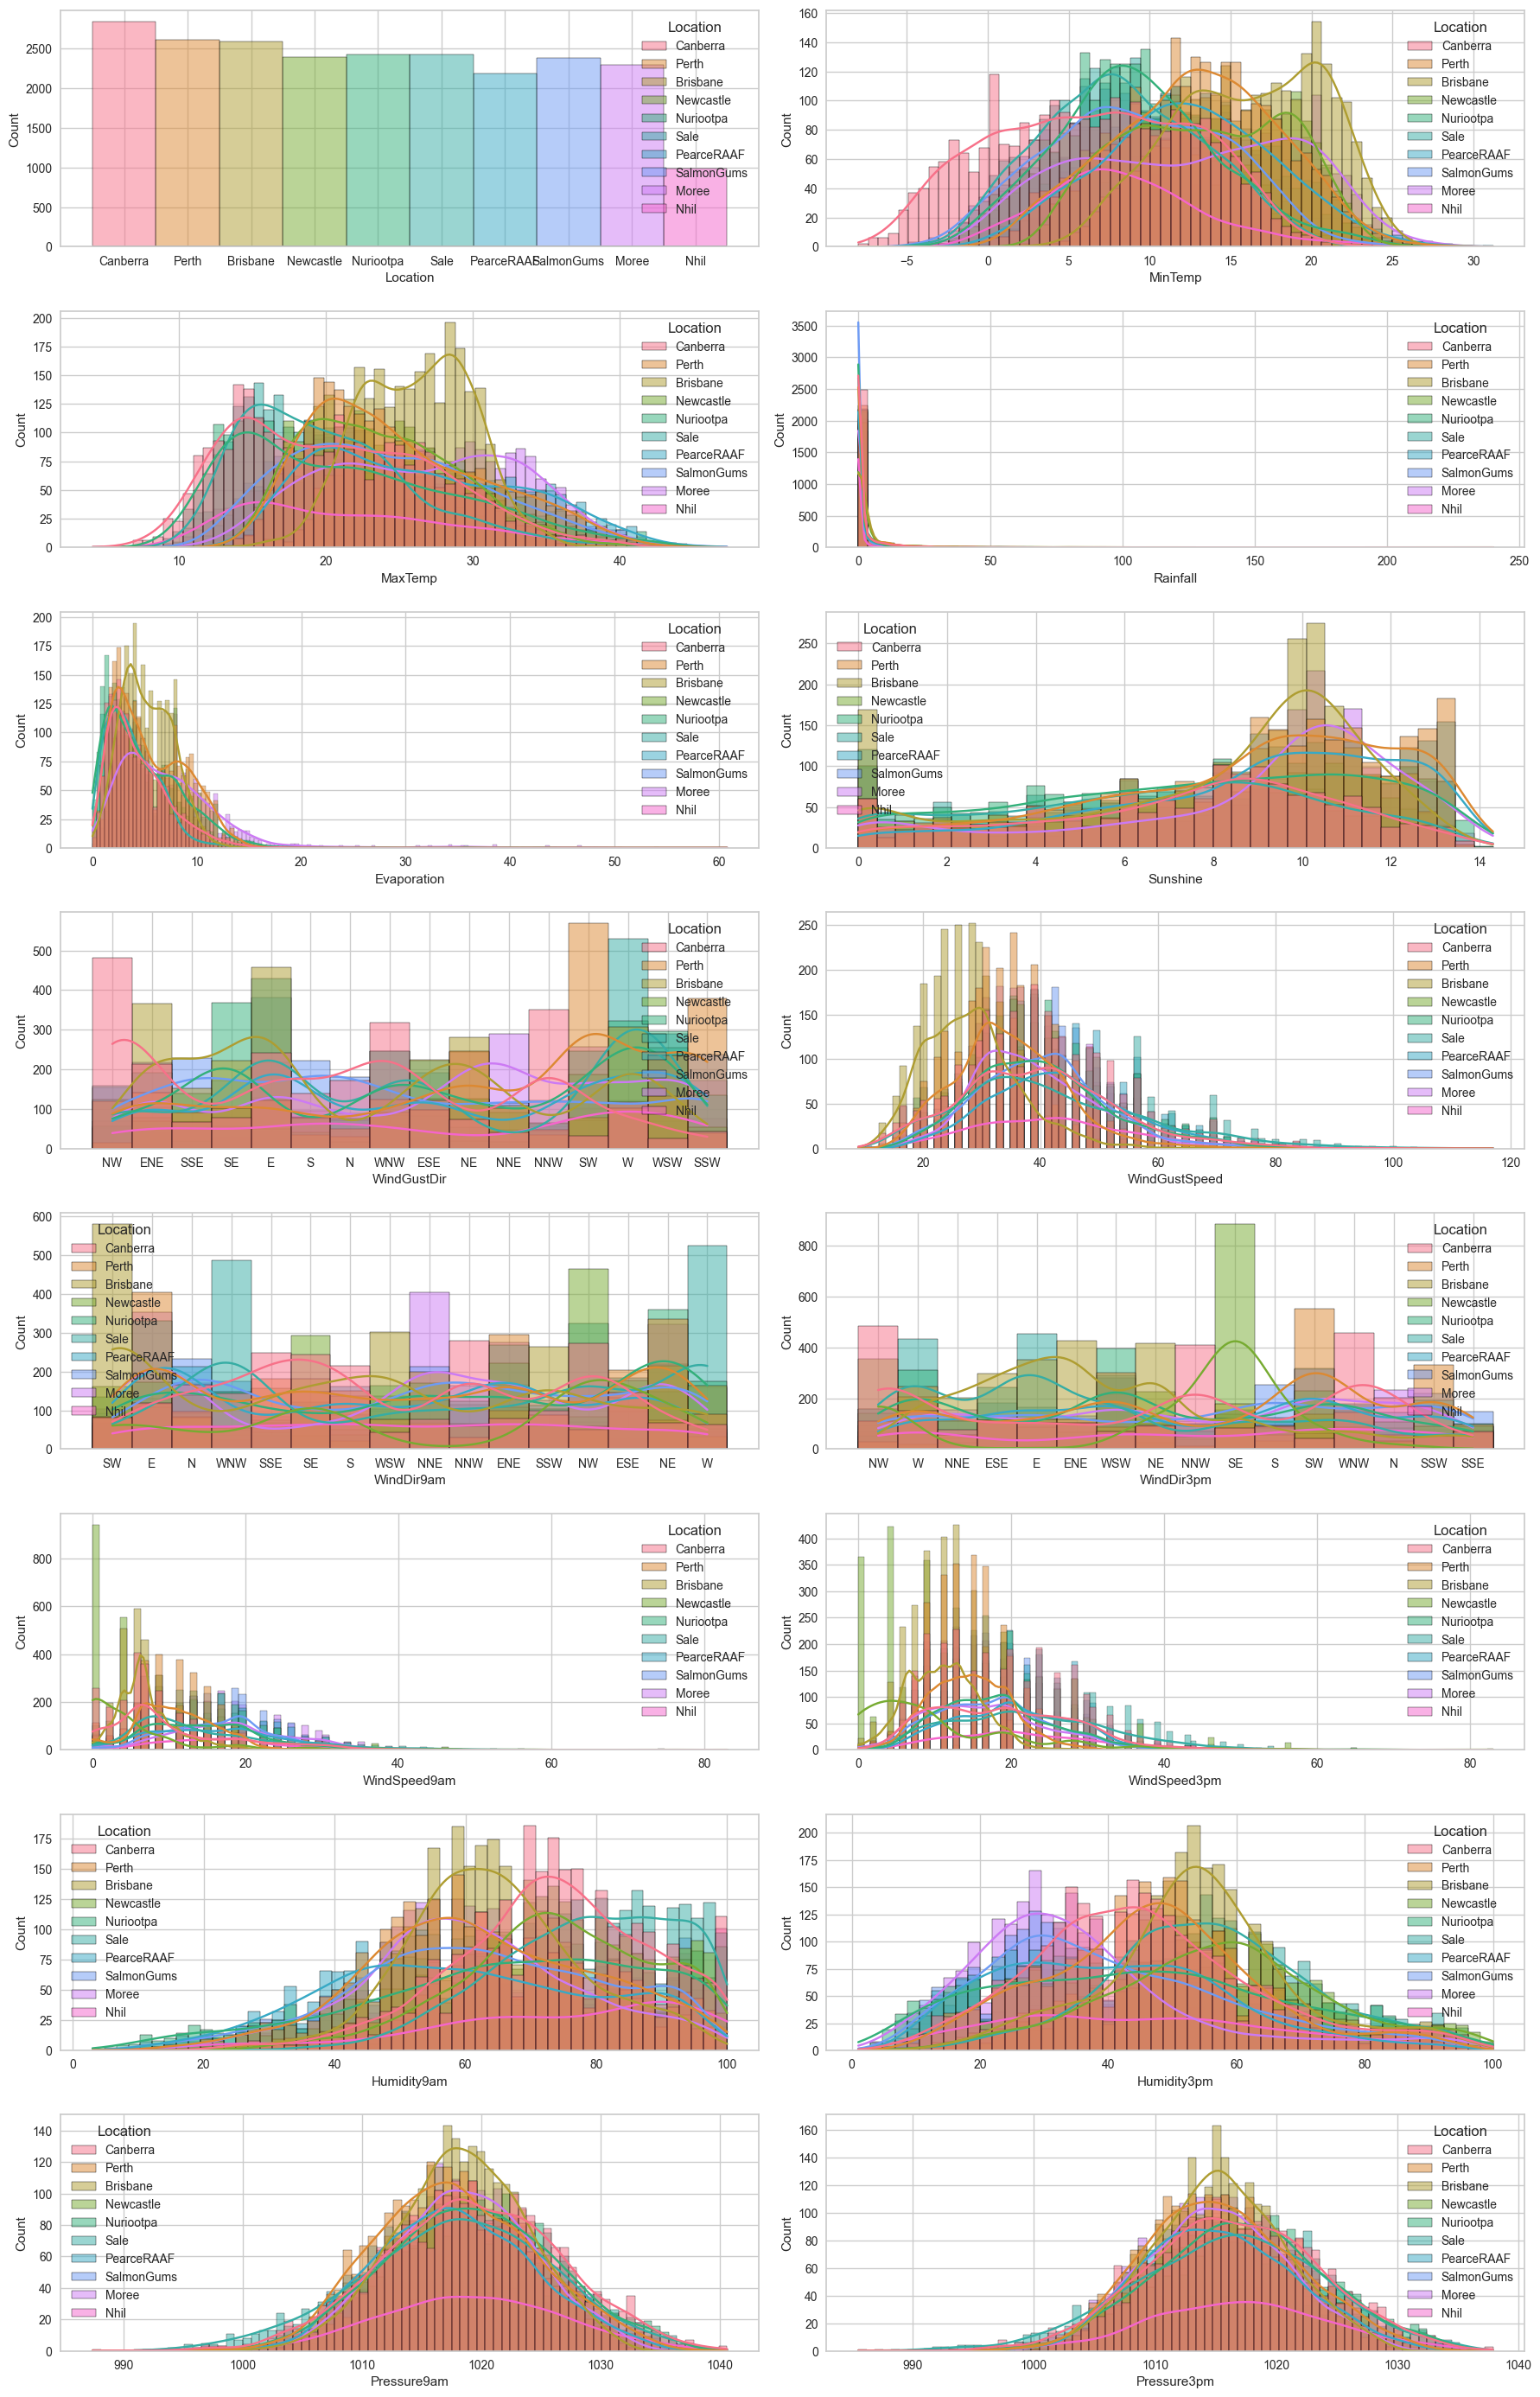

In [48]:
fig2, axes2 = plt.subplots(8,2)

for name, ax in zip(localidades, axes2.flatten()):
     if name == "Rainfall":
         sns.histplot(x=name, data=localidades, ax=ax,kde=True, bins=70, hue='Location')
     else:
         sns.histplot(x=name, data=localidades, ax=ax,kde=True, hue='Location')

fig2.set_size_inches(18,28)
plt.tight_layout()
plt.show()

Aquí vemos un poco más a fondo las distribuciones de las variables en cada ciudad, afirmando que no hay una diferencia significativa entre las mismas. La localidad que tiene menos datos que las demás ciudades y como se observaba en el boxplot anterior, muchas localidades tienen falta de sensado de datos en varias variables.

In [49]:
serie_tiempo = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
    'Sunshine', 'WindGustSpeed','week_year',
    'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
    'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
    'Temp3pm']

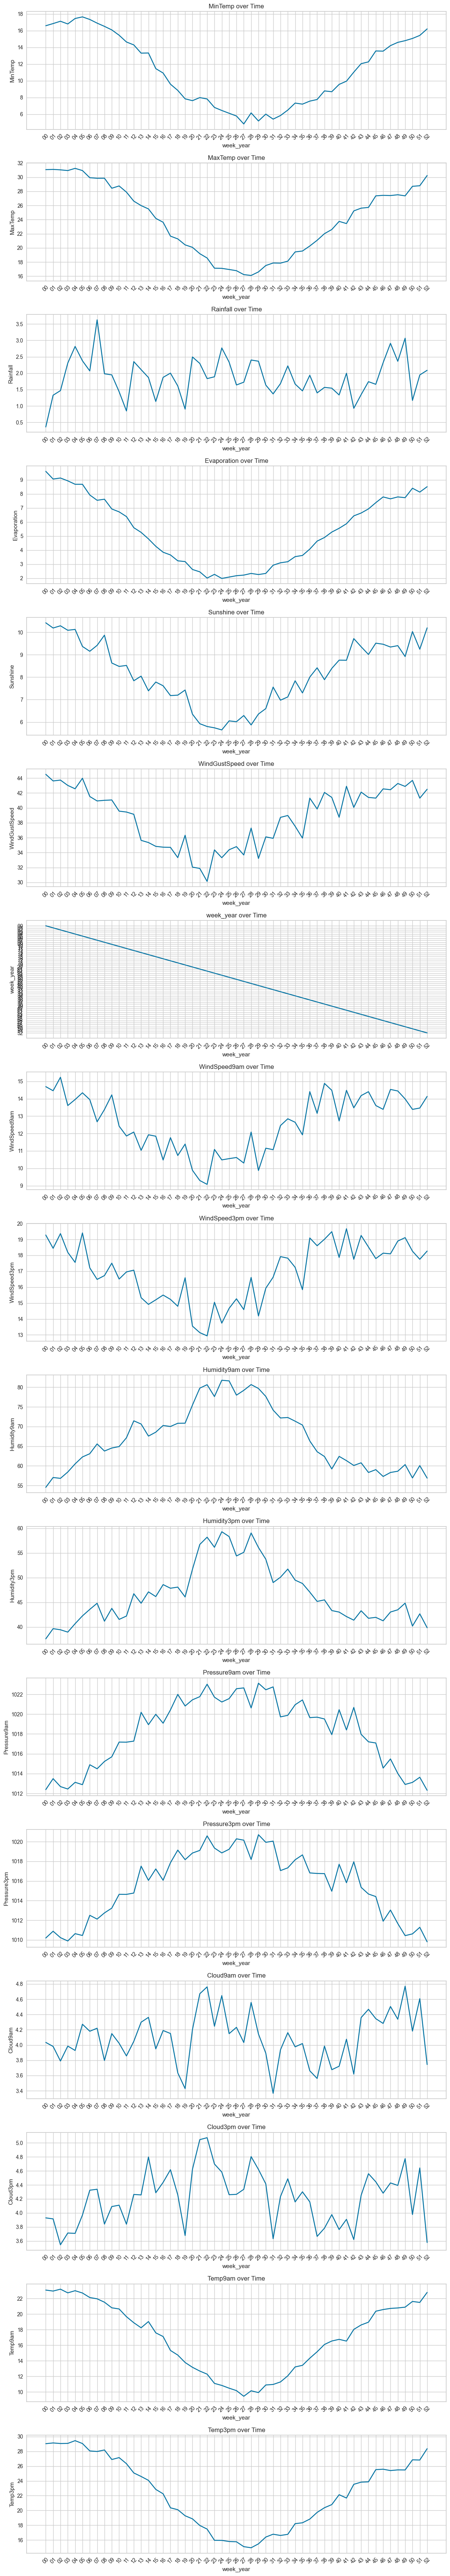

In [50]:
fig, axes = plt.subplots(nrows=len(serie_tiempo), ncols=1, figsize=(12, 4 * len(serie_tiempo)))

for i, var in enumerate(serie_tiempo):
    sns.lineplot(data=x_train_time[serie_tiempo], x='week_year', y=var, ax=axes[i])
    axes[i].set_title(f'{var} over Time')
    axes[i].set_xlabel('week_year')
    axes[i].set_ylabel(var)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Podemos observar que la mayoría de las variables tienen un comportamiento cíclico, lo que nos lleva a tomar la decisión de poder usar en las variables numéricas la interpolación con el parámetro method en time o una imputación iterativa con el estimador de arbol regresor, siendo que este funciona bien para datos no lineales.

In [51]:
categorical_vars = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

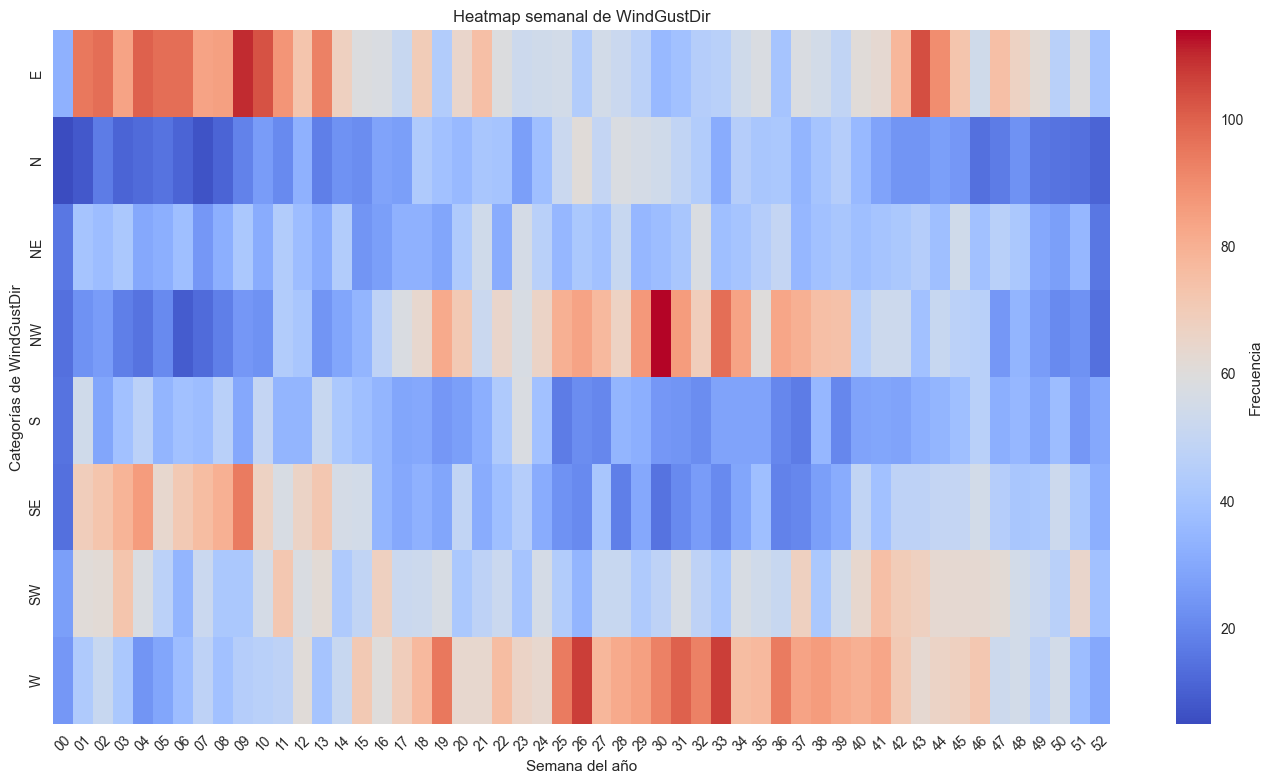

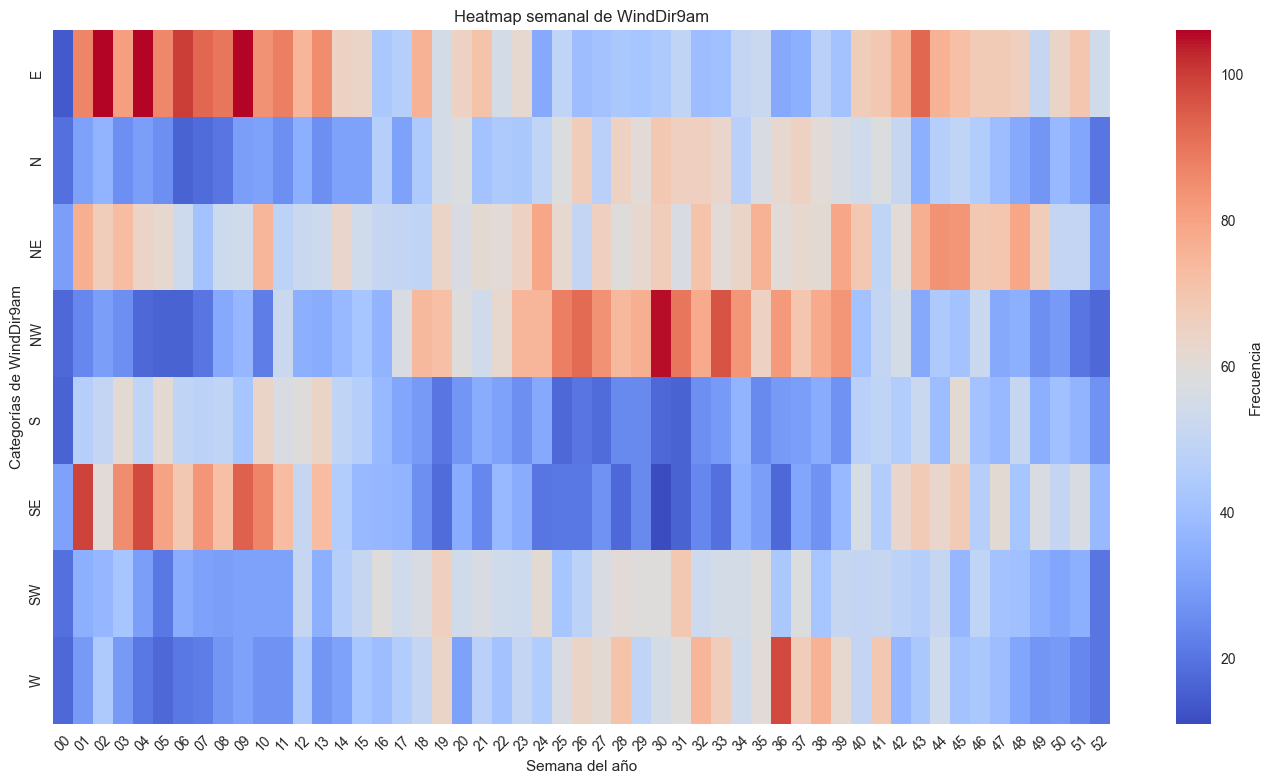

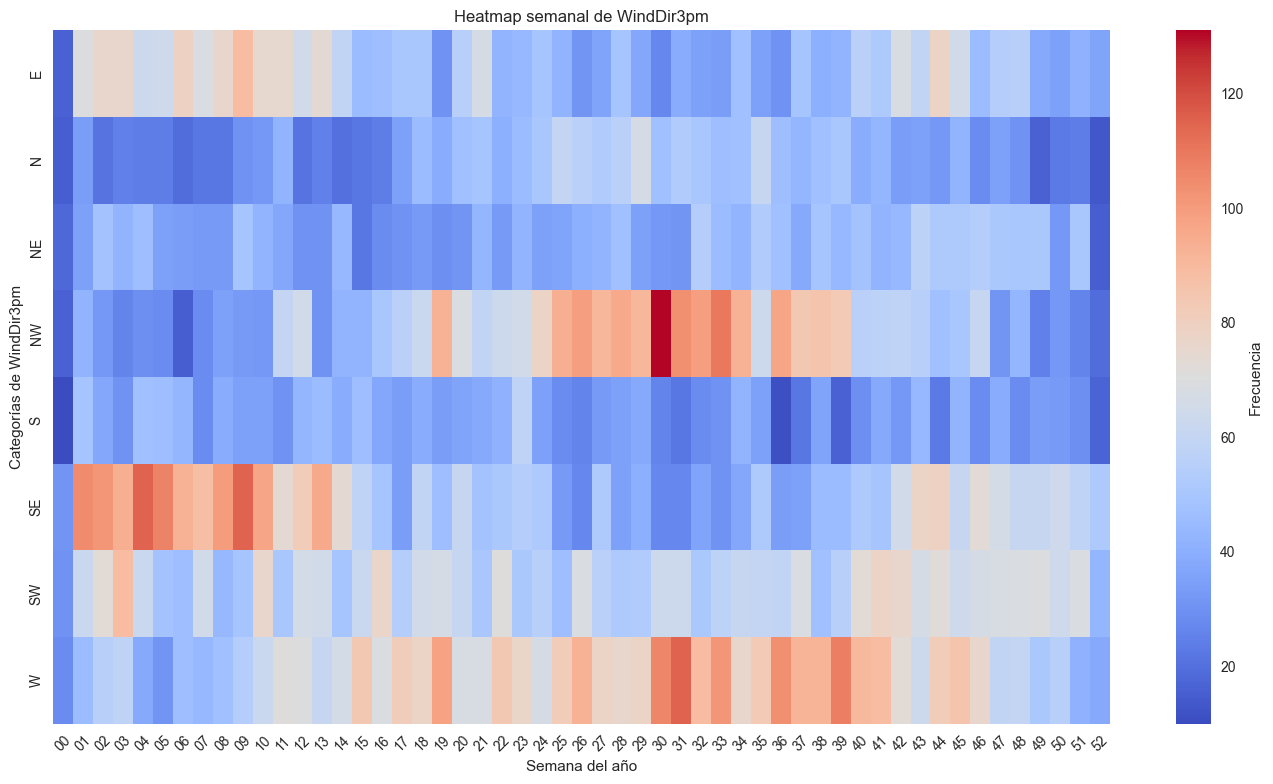

In [52]:
for var in categorical_vars:
    # Contar la frecuencia de cada categoría por semana
    category_counts = x_train.groupby(['week_year', var]).size().reset_index(name='Count')

    # Crear una matriz de semanas (filas: categorías, columnas: semanas)
    heatmap_data = category_counts.pivot(index=var, columns='week_year', values='Count').fillna(0)

    # Graficar el heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Frecuencia'})
    plt.title(f'Heatmap semanal de {var}')
    plt.xlabel('Semana del año')
    plt.ylabel(f'Categorías de {var}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Observamos que las variables categoricas también presentan un comportamiento cíclico y por lo tanto decidimos imputar los valores faltantes con una forward propagation, es decir, imputar con el valor anterior.

In [53]:
x_train_compl['RainTomorrow'].value_counts()

RainTomorrow
No     18635
Yes     4460
Name: count, dtype: int64

El dataset no esta balanceado, lo que nos indica que seria completamente necesario balancearlo para tener un mejor entrenamiento de nuestro modelo.

---
-------
-------

### Codificación 

In [54]:
x_train_codif = pd.get_dummies(data=x_train ,columns=["RainToday"], drop_first=True)
x_test_codif = pd.get_dummies(data=x_test, columns=["RainToday"], drop_first=True)

In [55]:
x_train_codif.columns 

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'week_year', 'RainToday_Yes'],
      dtype='object')

Transformamos los valores de RainToday de yes or no a True y False, para que luego pueda ser utilizada en los análisis, ya que los modelos no soportan str, así que los transformamos a bool mediante un dummy de pandas 

### Escalado

In [56]:
escalador_min_max = MinMaxScaler()

x_train_codif[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed',
                'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud3pm','Cloud9am']] = escalador_min_max.fit_transform(x_train_codif[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed',
                'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud3pm','Cloud9am']])

x_test_codif[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed',
                'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud3pm','Cloud9am']] = escalador_min_max.transform(x_test_codif[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed',
                'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud3pm','Cloud9am']])

Decidimos escalar con MinMax para tener un rango exacto de 0 a 1 y antes de imputar, ya que por el tipo de imputación que vamos a utilizar se es recomendado escalar antes de imputar.

In [57]:
x_train_imp_categ = x_train_codif[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location','week_year', 'RainToday_Yes']].fillna(method='ffill')
x_test_imp_categ = x_test_codif[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location', 'week_year', 'RainToday_Yes']].fillna(method='ffill')

Imputamos mediante forward propagation, localidad y week_year no tienen valores faltantes y por lo tanto no van a ser imputados.

In [58]:
num_vars = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed',
                'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud3pm','Cloud9am']

In [59]:
reg = DecisionTreeRegressor()

imp_mean = IterativeImputer(estimator=reg, max_iter=10, initial_strategy='median',imputation_order='ascending' ,random_state=120931).set_output(transform='pandas')
x_train_iterative_imputer_num = imp_mean.fit_transform(x_train_codif[num_vars])
x_test_iterative_imputer_num = imp_mean.transform(x_test_codif[num_vars])

Decidimos probar en utilizar IterativeImputer mediante una regresión lineal, también decidimos utilizar la mediana,porque al utilizar Iterativeimputer, se le puede asignar una estrategia de imputado, que terminamos optando por la mediana. 

La diferencia de este modelo con solo aplicarle la mediana es que este, realiza un proceso iterativo para mejorar las estimaciones de imputado, siendo que en cada iteración, remplaza los valores estimados por los nuevos y mejores. También utilizamos una regresión lineal para mejorar la imputación de los datos, generando así, que tengamos un método de imputado bastante robusto.

Usamos esta función de 'positivizar' variables, ya que nuestro imputador de valores faltantes (Iterativeimputer), imputa valores negativos en variables donde no pueden existir valores negativos, como en el caso de Rainfall, que sabemos que no puede existir lluvia negativa, y por eso transformamos los valores negativos a 0

Para los casos específicos de 'Cloud9am' y 'Cloud3pm', sabemos que el rango de sus valores son los números naturales positivos de 0 a 8, o sea, que se mide en octavos de cielo cubierto, donde 0 octas representa el cielo despejado y 8 representa el cielo cubierto, por eso para los valores mayores a 8, los redondeamos a 8 y los valores menores a 1, los redondeamos en 1.

### Decodificacion de variables

In [60]:
x_train_iterative_imputer_pos = positivisar(x_train_iterative_imputer_num)
x_test_iterative_imputer_pos = positivisar(x_test_iterative_imputer_num)

In [61]:
x_train_iterative_imputer_pos.reset_index(drop=True,inplace=True)
x_test_iterative_imputer_pos.reset_index(drop=True,inplace=True)
x_train_imp_categ.reset_index(drop=True,inplace=True)
x_test_imp_categ.reset_index(drop=True,inplace=True)

In [62]:
x_train_merge_iterative = merge_var(x_train_iterative_imputer_pos, x_train_imp_categ)
x_test_merge_iterative = merge_var(x_test_iterative_imputer_pos, x_test_imp_categ)

En este caso sacamos las variables anteriormente decodificadas del dataset, para luego mergearlo con el dataset anterior,

En esta celda de código estamos buscando codificar las variables de Date, Location, WindGustDir, WindDir9am y WindDir3pm. 

Cambiamos los tipos de fecha, que ya habíamos codificado anteriormente de fecha a semanas del año, ahora lo que buscamos, es darle una verdadera distancia entre semanas, ya que la última semana de diciembre (semana 52) está muy cerca de la primera semana de enero (semana 1), pero esto no puede ser plasmado con el tipo de codificación que tenemos de 1 a 52, por lo tanto, pensamos en implementar un sistema trigonométrico, donde ahora si se podrá representar una verdadera relación de distancia entre cada semana, realizando una para el coseno y otra para el seno, ya que si nos quedáramos con una única, estos datos, de forma única, serían erróneos.

Con WindGustDir, WindDir9am y WindDir3pm, pensamos algo similar, anteriormente reduciendo los 16 puntos cardinales a 8, ahora para darle un sistema de cercanía real, utilizamos el mismo sistema trigonométrico que con las fechas, pero ahora asignándole a cada punto cardinal un grado. Al ser 8, dividimos 8 sobre 360, dándonos que existe una separación de 45 grados entre cada punto cardinal, como se estipula para los puntos cardinales en la realidad

Con Location realizamos dummies, ya que no podemos plantear la distancia entre cada ciudad y tampoco podemos darle un valor ordinal, ya que una ciudad no es mayor o menor a otra, y esto realizaría que nuestro modelo de valores erróneos o sesgados

In [63]:
x_train_merge_iterative['week_year'] = x_train_merge_iterative['week_year'].astype(int)
x_test_merge_iterative['week_year'] = x_test_merge_iterative['week_year'].astype(int)

In [64]:
x_train_procesado_iterative = codificar_variables(x_train_merge_iterative)
x_test_procesado_iterative = codificar_variables(x_test_merge_iterative)

In [65]:
y_train_codif.reset_index(drop=True, inplace=True)

In [66]:
df_train_completo = x_train_procesado_iterative.copy()
df_train_completo['RainTomorrow'] = y_train_codif

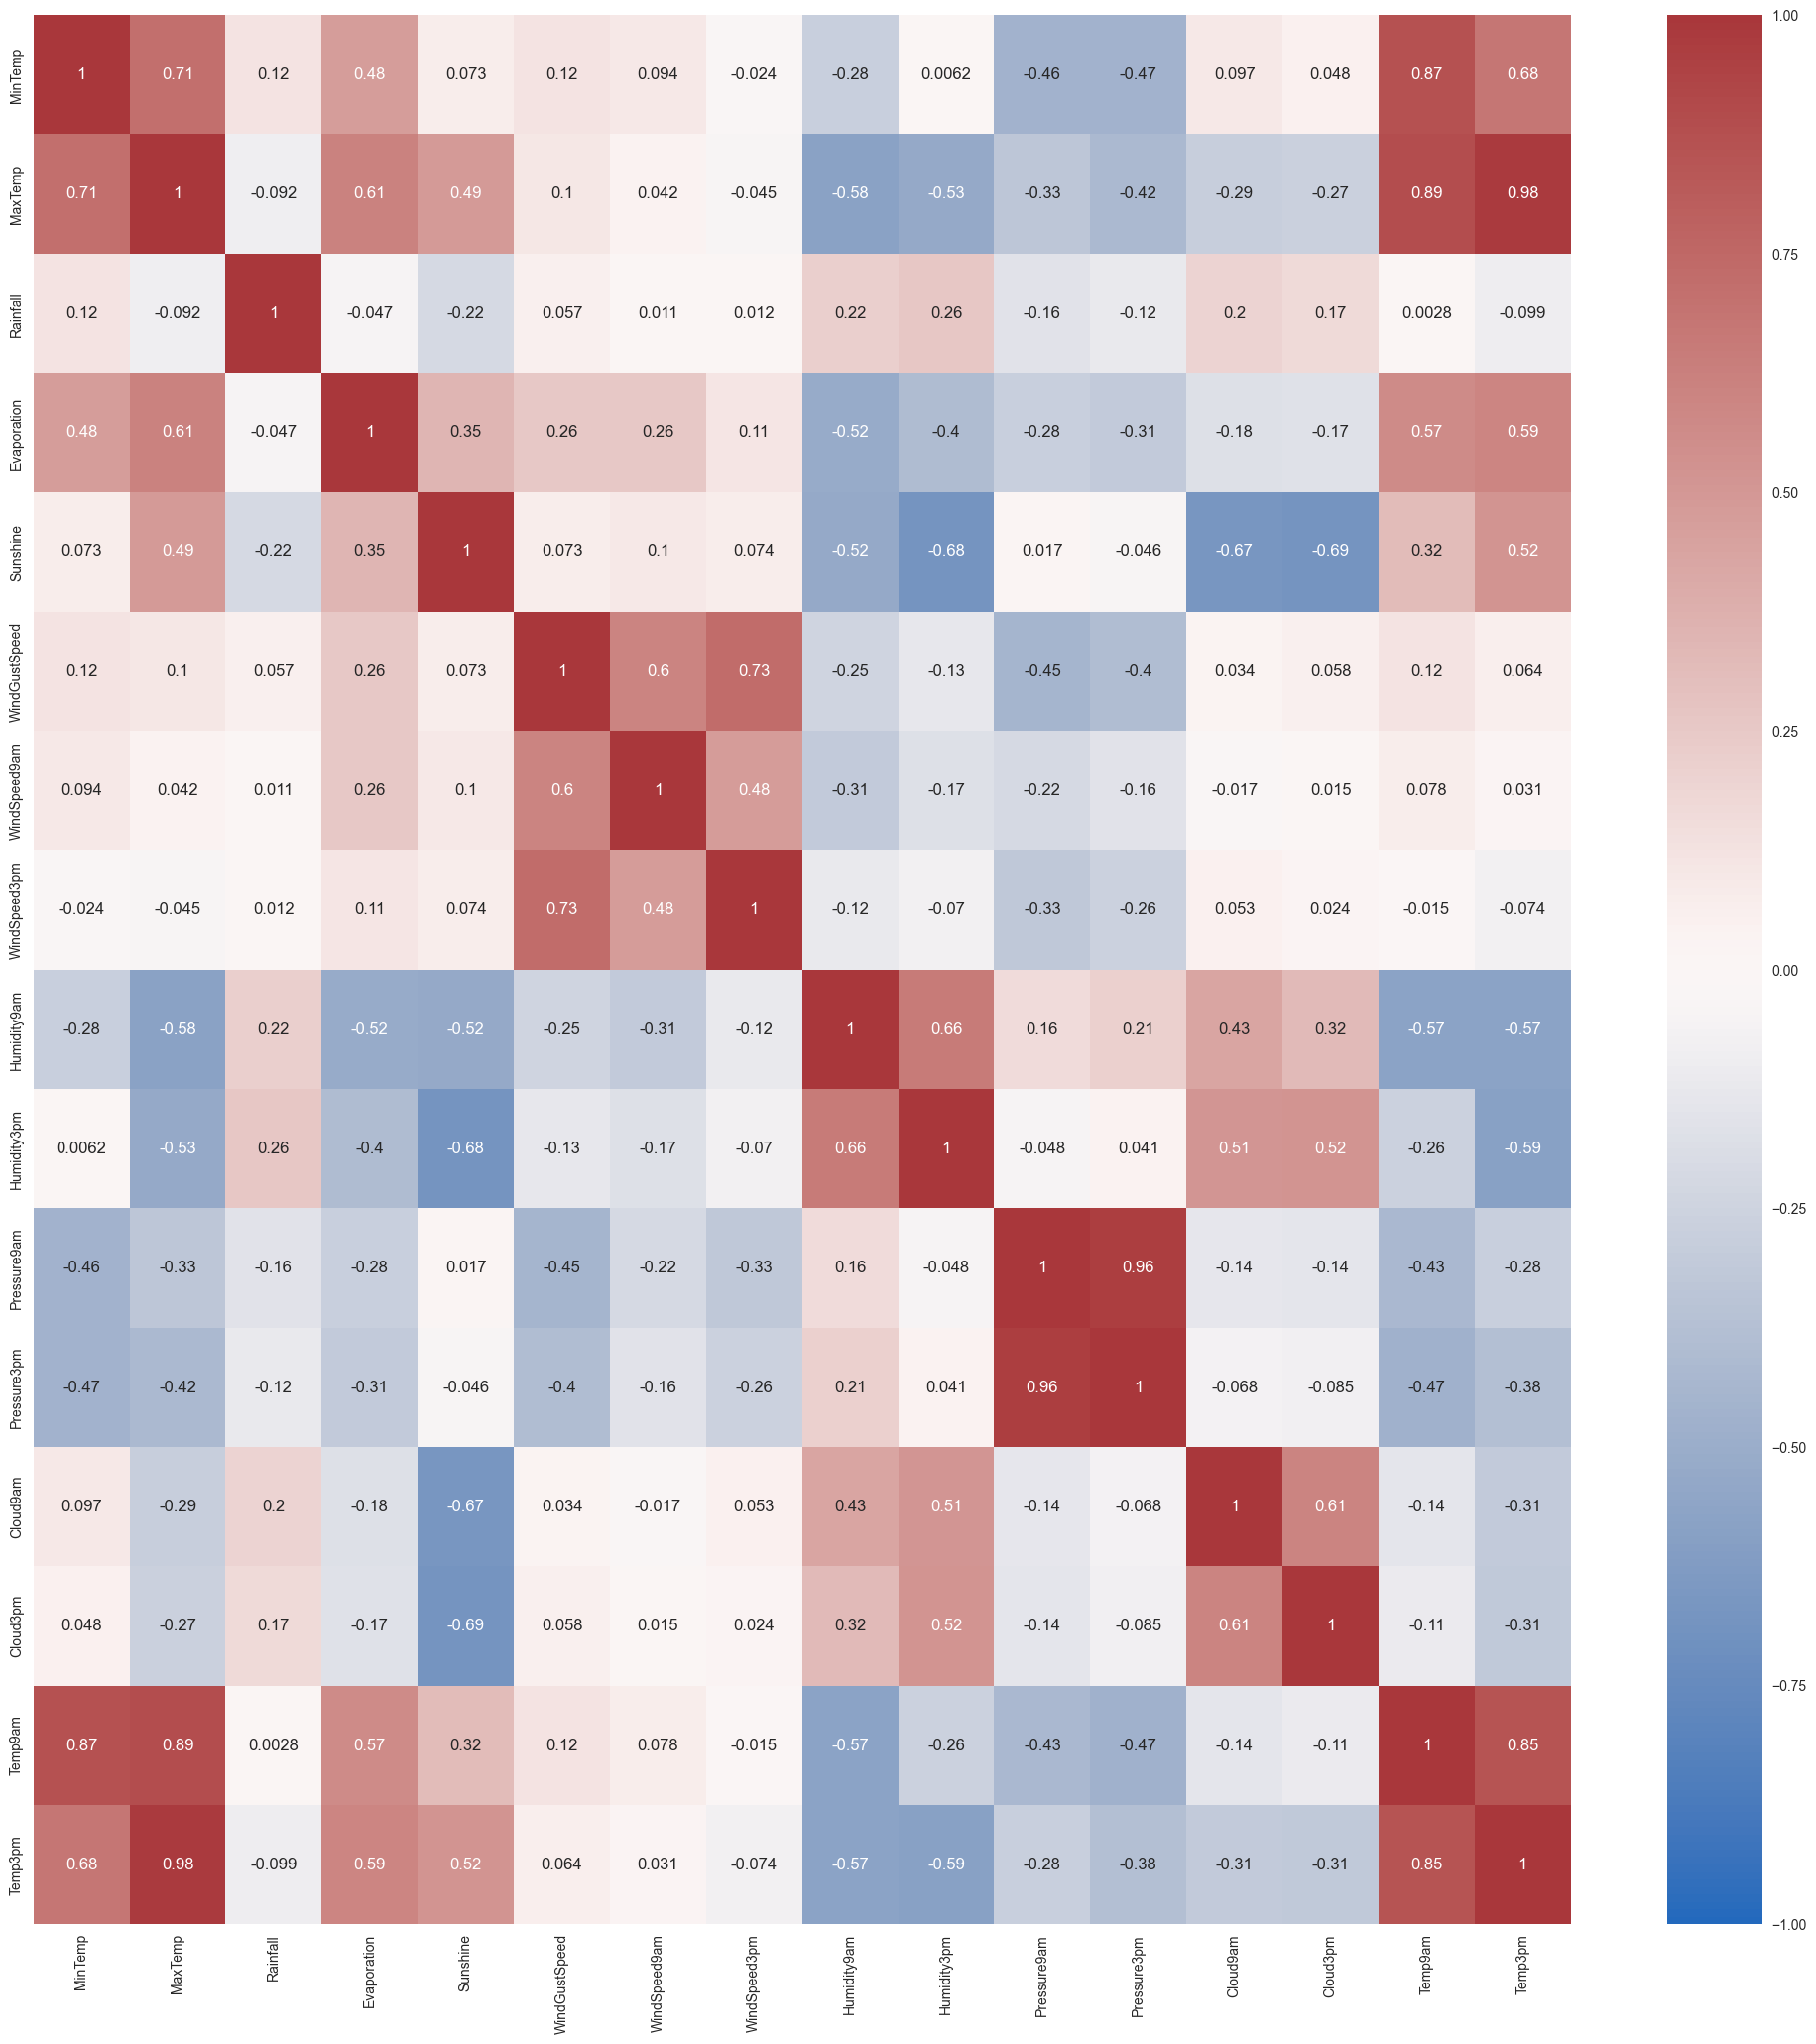

In [67]:
matriz_completa = df_train_completo[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']].corr()

fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(matriz_completa, annot=True, vmax=1, vmin=-1, cmap='vlag')
plt.show()

En la matriz de correlación de variables de Pearson, podemos observar que hay fuertes relaciones entre:

* Se observa que hay una relación positiva muy alta entre Temp9pm y MaxTemp de (0.89), esta es una correlación que ya podíamos intuir, ya que estamos viendo la relación entre la temperatura en un horario de tarde y la temperatura máxima. También vemos que la relación con MinTemp es de (0.87) por lo mismo, pero en este caso podemos suponer que es menor por el horario donde son medidas estas temperaturas

* Se observa una relación mucho menor entre Temp3pm y MinTemp de (0.68), esto se puede entender por el horario donde son tomados los datos de temperatura, diferente es el caso de la relación con MaxTemp, que es de (0.98) notando que tiene una relación positiva perfecta, esto es correcto si suponemos que la mayor temperatura se da en el rango de a las 3 pm, que es cuando son tomadas estas medidas de temperatura. También se puede observar una relación positiva alta con Evaporation (0.7), esto también podemos notar que está relacionado con una alta correlación de la temperatura máxima (MaxTemp), ya que a mayor temperatura, se espera una mayor evaporación. Además, una relación esperable con Temp9am de (0.86), siendo esta positivamente alta

* Se puede apreciar una relación negativa alta entre Cloud3pm y Sunshine de (-0.75), esto quiere decir que, en el caso de que haya mayor cantidad de nubes, va a ver una menor cantidad de luz solar, esto mismo sucede con Cloud9pm y Sunshine, teniendo también una relación negativa alta de (-0.73)

* Se puede observar una relación positiva casi perfecta entre Pressure3pm y Pressure9am de (0.96), lo que quiere decir que las presiones en distintos horarios suelen ser altamente similares y estar muy relacionadas

* Se puede notar que existe una relación negativa alta entre Humidity3pm y Sunshine de (-0.73), lo que nos da a entender que si nuestra humedad es muy alta es porque tenemos una cantidad muy baja de radiación solar o "Sunshine"

Concluimos que no tenemos la información, ni los valores de correlación suficientes para descartar una variable por ser dependiente de otra.

### Clasificación con regresión logística

#### Modelo con imputación iterativa

In [68]:
x_train_procesado_iterative.shape

(23095, 34)

In [69]:
modelo_relog =LogisticRegression(class_weight='balanced',random_state=25923)
modelo_relog.fit(x_train_procesado_iterative, y_train_codif)
y_probs_relog = modelo_relog.predict_proba(x_test_procesado_iterative)[:, 1]

y_pred_relog = modelo_relog.predict(x_test_procesado_iterative)


modelo_relog_desba = LogisticRegression(random_state=25923)
modelo_relog_desba.fit(x_train_procesado_iterative, y_train_codif)
y_probs_relog_desba = modelo_relog_desba.predict_proba(x_test_procesado_iterative)[:, 1]

y_pred_relog_desba = modelo_relog_desba.predict(x_test_procesado_iterative)

##### Métricas

In [70]:
metricas_relog = calcular_metricas_modelo(y_test_codif, y_pred_relog, 'Relog balanceada')
metricas_relog_desba = calcular_metricas_modelo(y_test_codif, y_pred_relog_desba, 'Relog desbalanceada')
display(metricas_relog,metricas_relog_desba)

Accuracy  Precision    Recall        F1  \
Relog balanceada - Llueve     0.792865   0.473174  0.752269  0.580939   
Relog balanceada - No Llueve  0.792865   0.932123  0.802440  0.862434   

                              Matthews   Jaccard   Wrecall  
Relog balanceada - Llueve     0.474154  0.409383  0.776545  
Relog balanceada - No Llueve  0.474154  0.409383  0.776545

Accuracy  Precision    Recall        F1  \
Relog desbalanceada - Llueve     0.861101   0.706612  0.465517  0.561269   
Relog desbalanceada - No Llueve  0.861101   0.883320  0.954409  0.917490   

                                 Matthews   Jaccard   Wrecall  
Relog desbalanceada - Llueve     0.497723  0.390114  0.625799  
Relog desbalanceada - No Llueve  0.497723  0.390114  0.625799

Se calculan las métricas de Accuaracy, Precicion, Recall, F1, Matthews, Jaccard y Wrecall para los modelos balanceados y desbalanceados del imputador iterativo.
En Accuaracy, medimos la proporción de predicciones correctas sobre el total de predichas, en el contexto de si llueve o no llueve, mostrando que en el modelo balanceado, la exactitud es menor que la del modelo desbalanceado, esto gracias a que el dataset está desbalanceado con respecto a los días lluviosos que a los que no. 

En Precisión, medimos de la proporción de verdaderos positivos sobre todos los ejemplos predichos como positivos, vemos que las predicciones del modelo balanceado están más cercanos en sus predicciones que el modelo desbalanceado que demuestra la baja cantidad de valores, teniendo una mucho mayor cantidad de datos para llueve que para no llueve

En Recall, dentro de la misma categoría, cuenta cuantos fueron correctamente clasificados. Las métricas demuestran que tenemos clases altamente desbalanceadas, al tener un reccal muy alto y uno muy bajo, por lo que no es muy acorde para este dataset

En F1, medimos la cantidad de falsos negativos y falsos positivos, dando valores medianamente acordes, ya que es buena para datasets desbalanceados, pudiendo ver en qué se respetan los valores bajos para cuando llueve y altos para cuando no llueve

Utilizamos Matthews, ya que considera todas las métricas de la matriz de confusión (TP, TN, FP, FN) y varía -1 y 1. En ambos modelos, Matthews valora las predicciones de forma global. En ambos modelos, las métricas son bastante bajas, indica cierta dificultad al momento de diferenciar de forma confiable en los días de lluvia de los que no.

El índice de Jaccard mide la intersección sobre la unión de las predicciones y las reales para la clase positiva, para ambos modelos. El índice de Jaccard es bajo para ambos, lo que sugiere que existe un nivel moderado de error en ambas predicciones, específicamente para los días que llueven

El Wrecall es una métrica que pondera los recall de ambas clases, que da más importancia a las clases en función de su frecuencia, mostrando que el Wrecall balanceado es superior al del desbalanceado, ya que para los días lluviosos el modelo demuestra valores muy dispares

##### Matriz de confusión

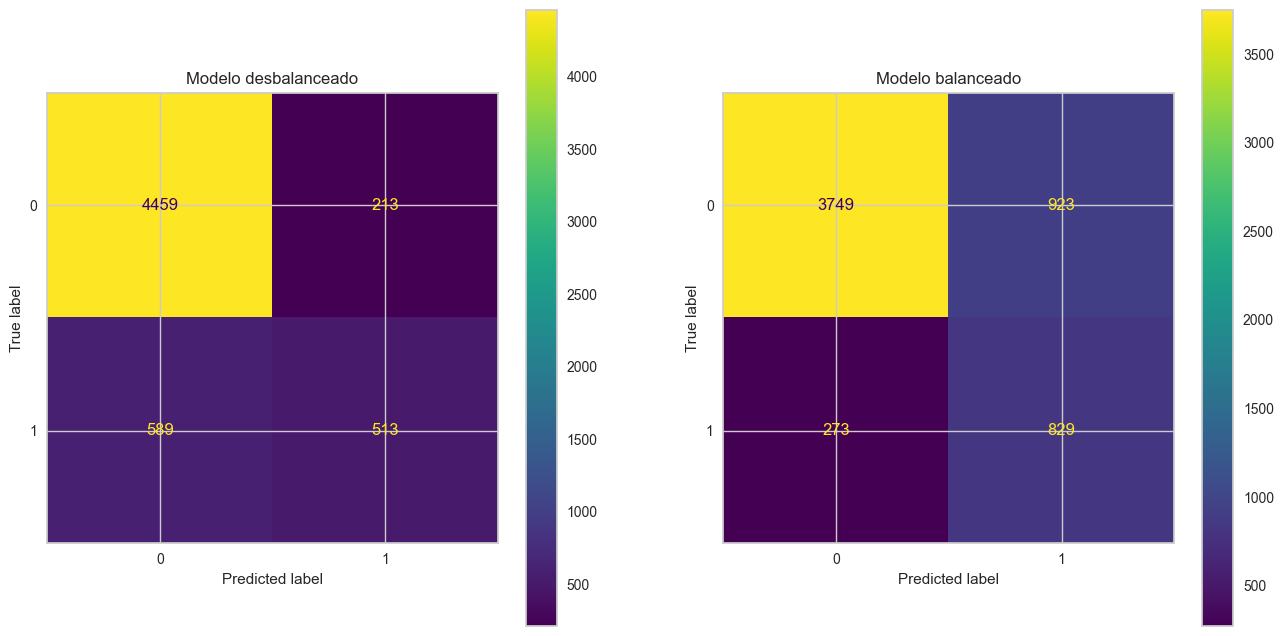

In [71]:
confusion_matrix_relog = confusion_matrix(y_test_codif, y_pred_relog)
confusion_matrix_relog_desba = confusion_matrix(y_test_codif, y_pred_relog_desba)

fig_matrix, axes_matrix = plt.subplots(1,2, figsize = (16, 8))

metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix_relog).plot(ax=axes_matrix[1])
axes_matrix[1].title.set_text('Modelo balanceado')

metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix_relog_desba).plot(ax=axes_matrix[0])
axes_matrix[0].title.set_text('Modelo desbalanceado')

plt.show()

Se observa que tenemos mas falsos negativos que falsos positivos, esto puede darse porque el dataset esta desbalanceado, en este caso teniendo pocos casos de lluvia. Por eso se entrenaron 2 modelos uno donde se utiliza el hiperparametro class_weight en balanced, simulando un balanceo del dataset, y otro donde se utiliza el hiperparametro class_weight por default siendo None.

Los falsos negativos quieren decir que el modelo predice que no iba a llover y en el caso real llueve.
Los falsos positivos quieren decir que el modelo precide que va a llover y en el caso real no llueve.

Se observa el trade-off entre TP-FN y TN-FP en los dos modelos, es decir, en el desbalanceado se predice la mitad de veces que va a llover, teniendo un recall de lluvia muy bajo, pero un recall de no lluvia muy alto, pero en el balanceado se predice el más el doble la lluvia, obteniendo más falsos positivos a cambio de predecir mejor la lluvia y tener menos falsos negativos.

##### Curva ROC

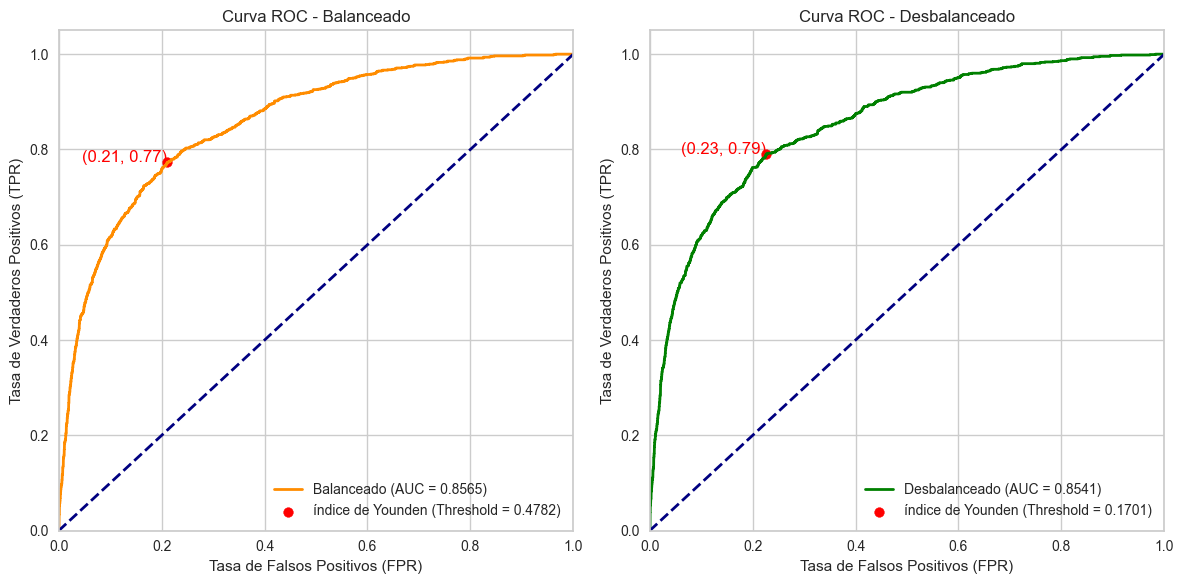

In [72]:
funciones_roc(y_test_codif, y_probs_relog, 'Balanceado', y_probs_relog_desba, 'Desbalanceado')

Vemos que los valores de ambas curvas ROC son similares gracias a que el área bajo la curva es símilar. Resultando en que la decisión para elegir uno de los dos modelos sea sobre la métrica seleccionada para la comparación de los modelos. 

### Modelo base


In [73]:
x_test_procesado_iterative['Humidity3pm']

0       0.454545
1       0.212121
2       0.525253
3       0.242424
4       0.121212
          ...   
5769    0.303030
5770    0.525253
5771    0.484848
5772    0.484848
5773    0.595960
Name: Humidity3pm, Length: 5774, dtype: float64

In [74]:
umbral = x_train_procesado_iterative['Humidity3pm'].mode().iloc[0]

y_pred_avg = (x_test_procesado_iterative['Humidity3pm'] > umbral).astype(int)

y_pred_avg_prob = 1 / (1 + np.exp(-12 * (x_test_procesado_iterative['Humidity3pm'] - umbral)))

escribir sobre esto

#### Métricas

In [75]:
metricas_base = calcular_metricas_modelo(y_test_codif, y_pred_avg, 'Modelo Base')
display(metricas_base)

Accuracy  Precision    Recall        F1  Matthews  \
Modelo Base - Llueve     0.701074   0.357012  0.706897  0.474421  0.329542   
Modelo Base - No Llueve  0.701074   0.910078  0.699700  0.791142  0.329542   

                          Jaccard  Wrecall  
Modelo Base - Llueve     0.310978  0.70328  
Modelo Base - No Llueve  0.310978  0.70328

#### Matriz de confusión

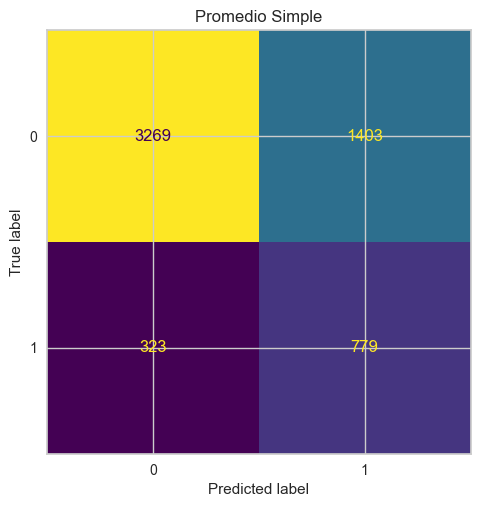

In [76]:
confusion_matrix_avg = confusion_matrix(y_test_codif, y_pred_avg)

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_avg).plot(colorbar=False)
plt.title('Promedio Simple')

plt.show()

Podemos observar que en este modelo, como fue visto en las métricas antes calculadas, los FP son similares a los TN y los FN son similares a los TP. La métrica que me permite deducir esto es el Wrecall.

#### Curva ROC

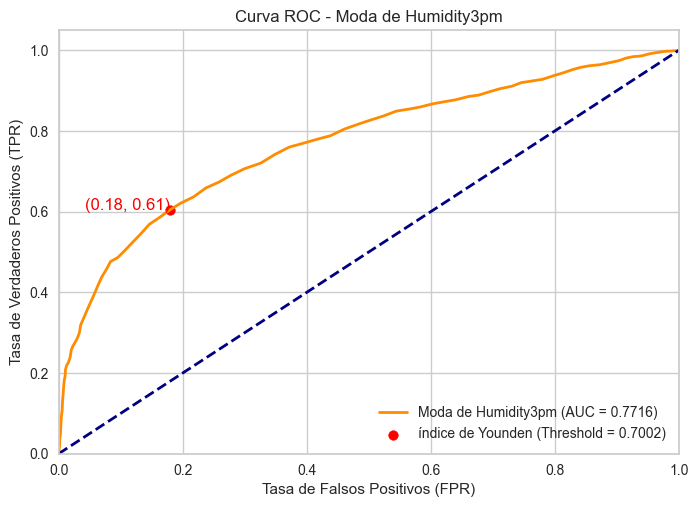

In [77]:
funciones_roc(y_test_codif, y_pred_avg_prob, 'Moda de Humidity3pm')

escribi sobre esto

### Optimizar la selección de hiperparámetros.

#### Validación cruzada

In [78]:
my_scorer = make_scorer(calcular_wrecall_estimador, greater_is_better=True)

modelo_relog_val =LogisticRegression(class_weight='balanced',random_state=25923)
modelo_relog_desba_val =LogisticRegression(random_state=25923)

time_split = TimeSeriesSplit(n_splits=5)

val_relog_balanced_iterative = cross_val_score(modelo_relog_val, x_train_procesado_iterative, y_train_codif, scoring=my_scorer, cv=time_split.split(x_train_procesado_iterative))
val_relog_desba_iterative = cross_val_score(modelo_relog_desba_val, x_train_procesado_iterative, y_train_codif, scoring=my_scorer, cv=time_split.split(x_train_procesado_iterative))


validations = pd.DataFrame(data=[val_relog_balanced_iterative,val_relog_desba_iterative], index=['Iterative relog - balanceado', 'Iterative relog - desbalanceado'])

validations['promedios'] = [np.mean(val_relog_balanced_iterative),np.mean(val_relog_desba_iterative)]
display(validations)

0         1         2         3  \
Iterative relog - balanceado     0.798803  0.790775  0.776542  0.794768   
Iterative relog - desbalanceado  0.643794  0.647586  0.632612  0.651159   

                                        4  promedios  
Iterative relog - balanceado     0.787187   0.789615  
Iterative relog - desbalanceado  0.615899   0.638210

Observamos que utilizando kfolds (timeseriessplit, ya que es un serie de tiempo) se pueden optimizar hiperparametros de una manera sencilla, el unico problema es que esta optimización es muy manual, siendo que tendría que ir cambiando los hiperparametros en cada ejecución

#### Optuna

In [79]:
def optuna_parametros(trial):
    penalty = trial.suggest_categorical('penalty', ['l2','l1',None])
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    tol = trial.suggest_float('tol', 0.000001, 100)
    C = trial.suggest_loguniform('C', 0.000001, 100)

    if (penalty == 'none' and solver != 'lbfgs') or \
        (penalty == 'l1' and solver not in ['liblinear', 'saga']) or \
        (penalty == 'elasticnet' and solver != 'saga'):
        return float('-inf')


    params = { 'penalty': penalty,'solver': solver, 'C': C, 'tol': tol, 'class_weight': 'balanced', 'random_state': 25923}

    model = LogisticRegression(**{k: v for k, v in params.items() if v is not None})
    model.fit(x_train_procesado_iterative, y_train_codif)
    
    y_pred = model.predict(x_test_procesado_iterative)
    scores = calcular_wrecall_estimador(y_test_codif, y_pred)

    return scores

study = optuna.create_study(direction='maximize')
study.optimize(optuna_parametros, n_trials=500)

best_optuna_params = study.best_params
best_optuna_model = LogisticRegression(**best_optuna_params, class_weight='balanced', random_state=25923)
best_optuna_model.fit(x_train_procesado_iterative, y_train_codif)

y_pred_opt_optuna = best_optuna_model.predict(x_test_procesado_iterative)
optuna_metrics = calcular_wrecall_estimador(y_test_codif, y_pred_opt_optuna)
y_pred_opt_optuna_prob = best_optuna_model.predict_proba(x_test_procesado_iterative)[:,1]

[I 2024-11-26 15:12:15,901] A new study created in memory with name: no-name-4ef5a8c1-38c7-4873-8b25-07ccbe4a99a9
[I 2024-11-26 15:12:15,928] Trial 0 finished with value: 0.0 and parameters: {'penalty': None, 'solver': 'lbfgs', 'tol': 34.23599161255395, 'C': 7.534314675038552}. Best is trial 0 with value: 0.0.
[I 2024-11-26 15:12:15,955] Trial 1 finished with value: 0.0 and parameters: {'penalty': None, 'solver': 'newton-cg', 'tol': 75.46970131915818, 'C': 5.286251197109659e-06}. Best is trial 0 with value: 0.0.
[I 2024-11-26 15:12:15,987] Trial 2 finished with value: 0.5320424483951824 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'tol': 1.1747063736700758, 'C': 9.593358333314279e-06}. Best is trial 2 with value: 0.5320424483951824.
[I 2024-11-26 15:12:16,019] Trial 3 finished with value: 0.7402295376503875 and parameters: {'penalty': None, 'solver': 'sag', 'tol': 99.8435692643042, 'C': 0.00025929659372688635}. Best is trial 3 with value: 0.7402295376503875.
[I 2024-11-26 1

In [80]:
print(optuna_metrics, best_optuna_params)

0.776824157722885 {'penalty': 'l1', 'solver': 'saga', 'tol': 67.42719023472759, 'C': 0.11766239381801483}


Decidimos utilizar Optuna, ya que al tener varios hiperparametros para ajustar gridsearch era demasiado lento y es sobre valores discretos que dificulta la selección de los mismos, aún asi tiene la posibilidad de usar rangos, pero esto puede terminar en una búsqueda demasiado extensa y que tardaría mucho en terminar. Por otro lado RandomSearch no tiene el mismo problema que gridsearch ya que podemos limitar los valores que busca en la grilla, pero al ser random terminamos haciendo muchas tiradas para llegar a un punto óptimo, lo que no me parece tan cómodo o confiable. 

Optuna tiene la caracteristica de buscar de manera eficaz sobre los rangos de valores que se le ingresan para entrenar al modelo, ahorrando tiempo y acercandose a valores bastante óptimos sin tardar demasiado. Aun así Optuna no es perfecto, ya que tiene un funcionamiento parecido a RandomSearch para inicializar la búsqueda los hiperparametros, por lo tanto es obvio que no siempre encontrará el mejor máximo local de la métrica.

##### Métricas 

In [81]:
calcular_metricas_modelo(y_test_codif, y_pred_opt_optuna, 'Modelo Optimizado con Optuna')

Accuracy  Precision    Recall  \
Modelo Optimizado con Optuna - Llueve     0.782646   0.458537  0.767695   
Modelo Optimizado con Optuna - No Llueve  0.782646   0.934843  0.786173   

                                                F1  Matthews   Jaccard  \
Modelo Optimizado con Optuna - Llueve     0.574143  0.466777  0.402665   
Modelo Optimizado con Optuna - No Llueve  0.854087  0.466777  0.402665   

                                           Wrecall  
Modelo Optimizado con Optuna - Llueve     0.776824  
Modelo Optimizado con Optuna - No Llueve  0.776824

##### Matriz de confusión

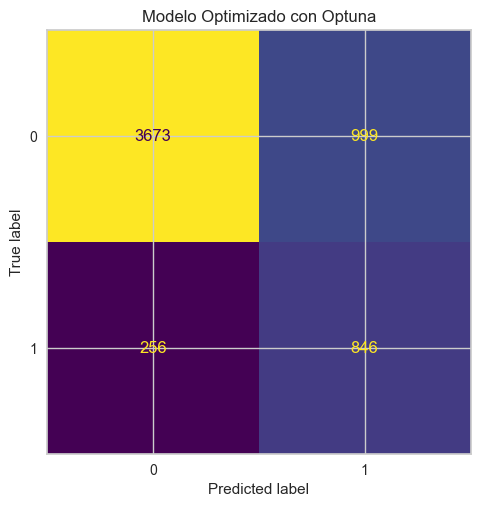

In [82]:
confusion_matrix_opt_optuna = confusion_matrix(y_test_codif, y_pred_opt_optuna)

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_opt_optuna).plot(colorbar=False)
plt.title('Modelo Optimizado con Optuna')
plt.show()

Se observa que no hay mucha diferencia con la matriz de confusión del modelo sin optimización, lo que si parece haber un pequeño trade-off entre TP-FN y TN-FP, es decir, obtengo mejores predicciones sobre los días de lluvia a cambio de predecir un poco peor los días que no llueve. 

##### Curva ROC

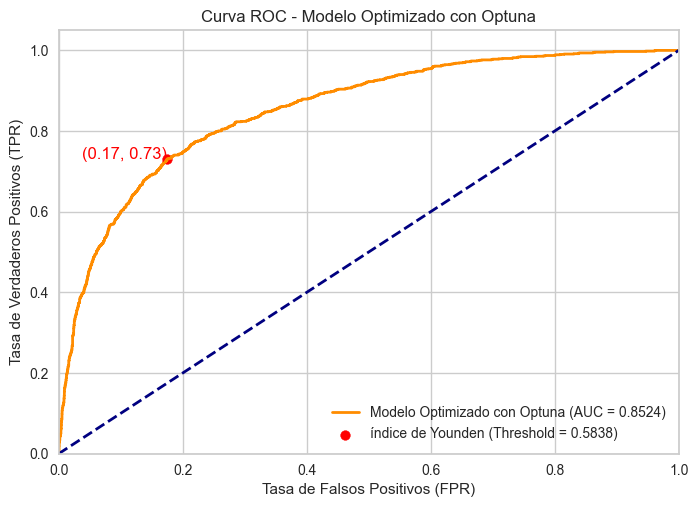

In [83]:
funciones_roc(y_test_codif, y_pred_opt_optuna_prob, 'Modelo Optimizado con Optuna')


### Explicabilidad de los modelos

#### Interpretación local con SHAP

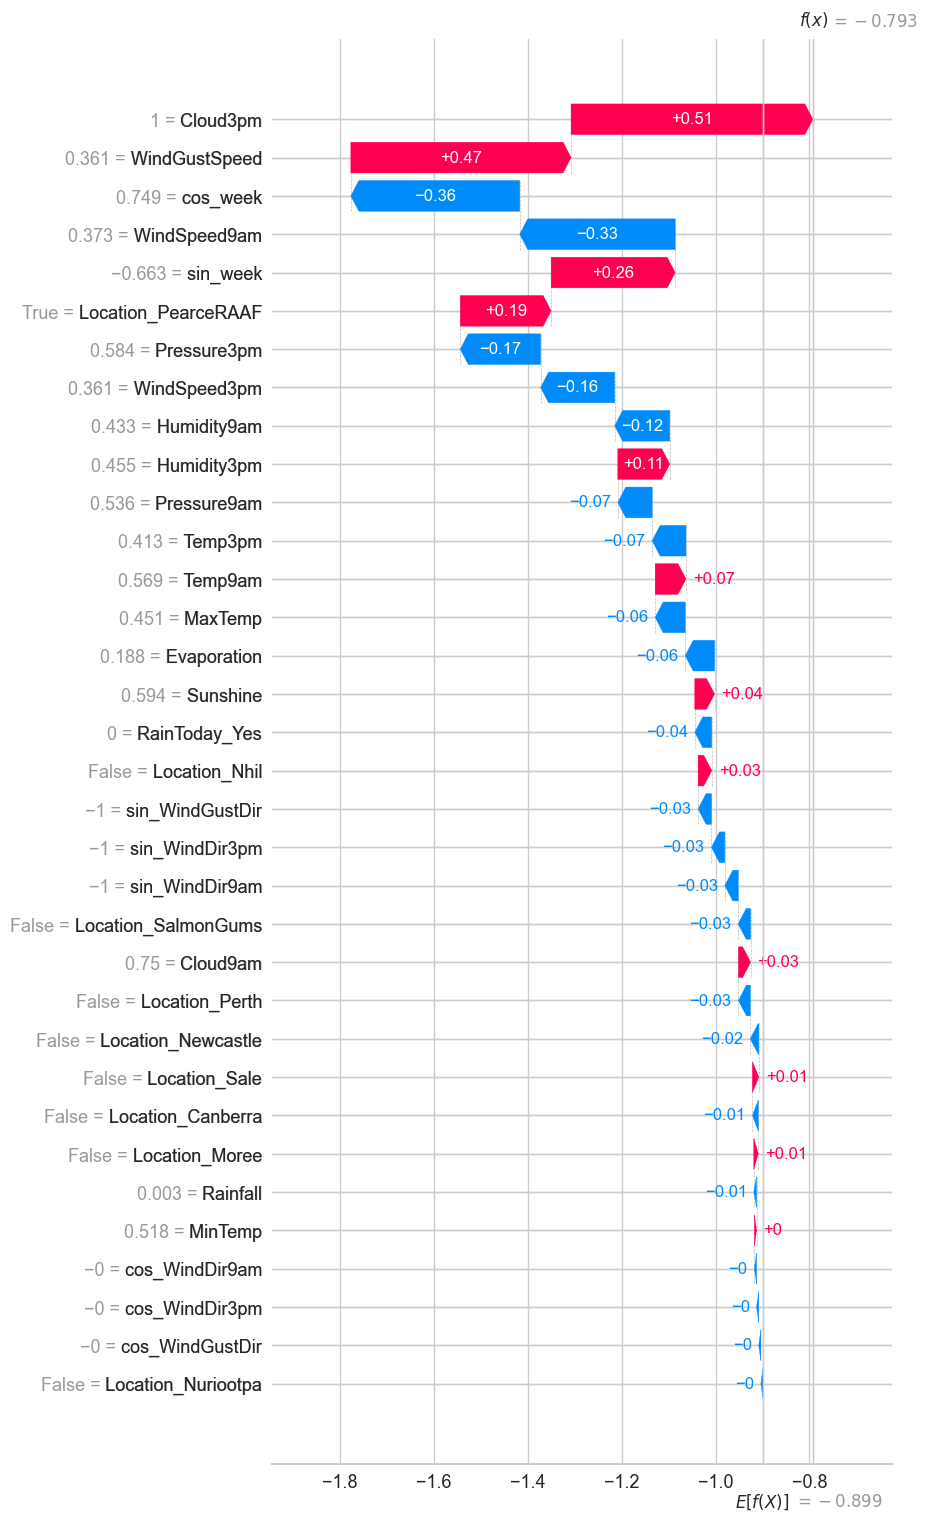

In [84]:
explainer = shap.Explainer(modelo_relog, x_test_procesado_iterative, feature_names=x_train_procesado_iterative.columns)
shap_values = explainer(x_test_procesado_iterative)
shap.plots.waterfall(shap_values[0], max_display=35)

Interpretando las variables localmente en el primer dato, se observa que las variables más importantes son Cloud3pm, Temp9am, week(siendo el seno y coseno), Localidad (siendo las 9 variables de onehotencoding), Temp3pm y RainToday_Yes. Por otro lado las menos importantes son Evaporation, MaxTemp, Humidity3pm, Rainfall y Humidity9am.

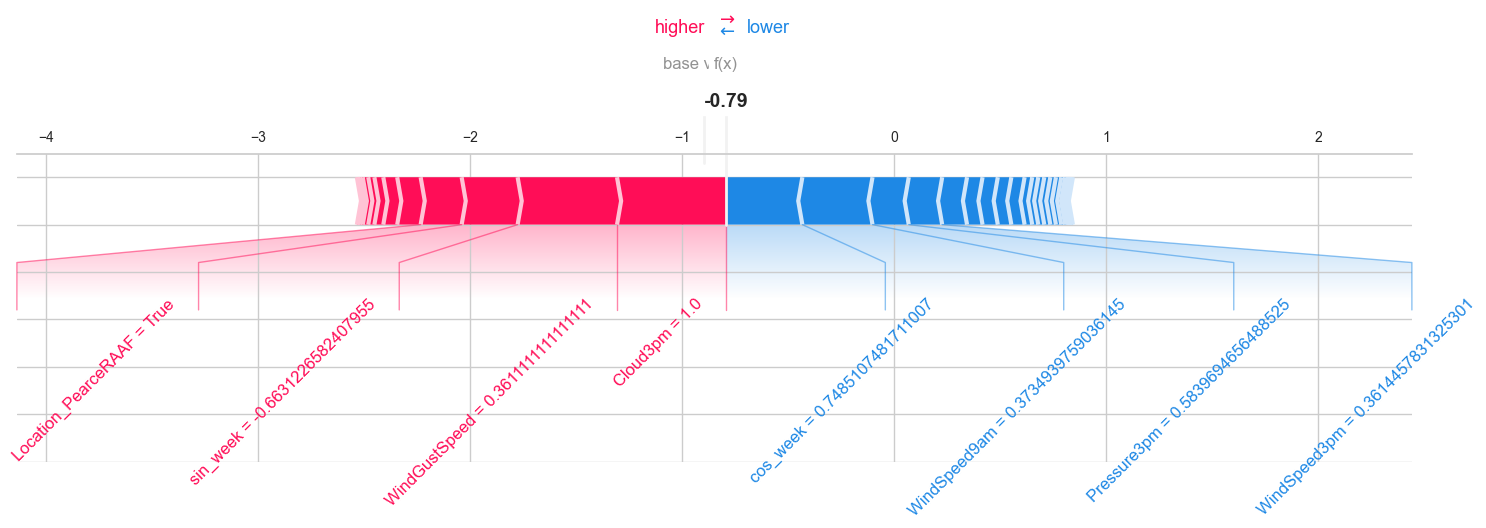

In [85]:
shap_values_exp = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=x_test_procesado_iterative.iloc[0].values, feature_names=x_test_procesado_iterative.columns)
shap.force_plot(shap_values_exp, matplotlib=True, figsize=(18, 4), text_rotation=45)

#### Interpretación global con SHAP

In [86]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=x_train_procesado_iterative.columns, data=x_test_procesado_iterative)

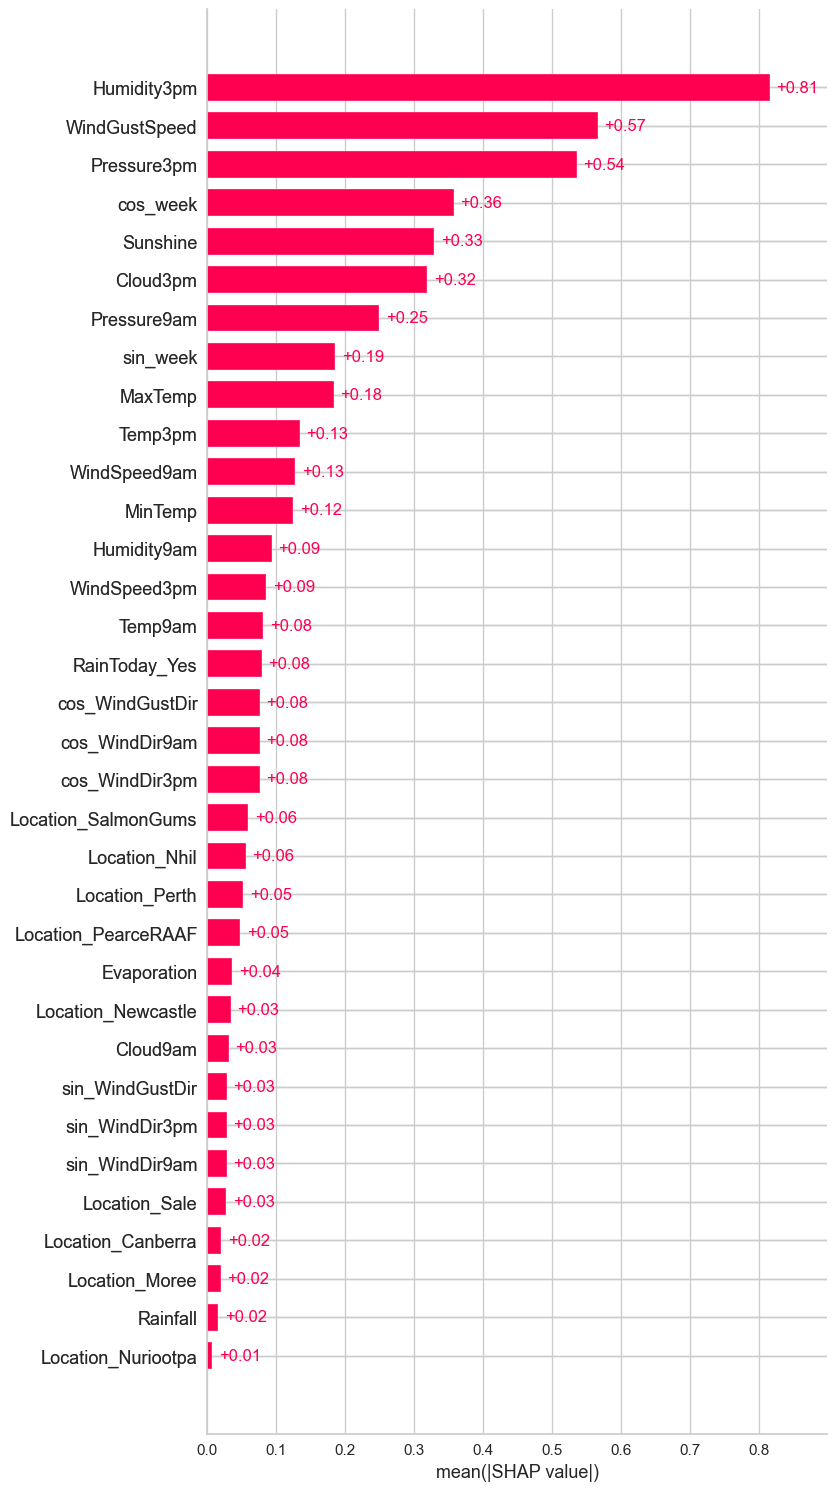

In [87]:
shap.plots.bar(explanation, max_display=35)

Interpretando las variables globalmente, se observa que las más importantes son Humidity3pm, WindGustSpeed, Pressure3pm, Sunshine, Cloud3pm, Temp3pm , week (siendo sin_week y cos_week en conjunto) y Pressure9am. Por otro lado, las menos importantes son MinTemp, WindSpeed3pm,  Rainfall, Temp9am, Evaporation.

In [88]:
x_train_procesado_iterative = x_train_procesado_iterative.astype({col: 'int32' for col in x_train_procesado_iterative.select_dtypes('bool').columns})

In [89]:
explainer = shap.Explainer(modelo_relog, x_train_procesado_iterative)
shap_values = explainer(x_train_procesado_iterative)

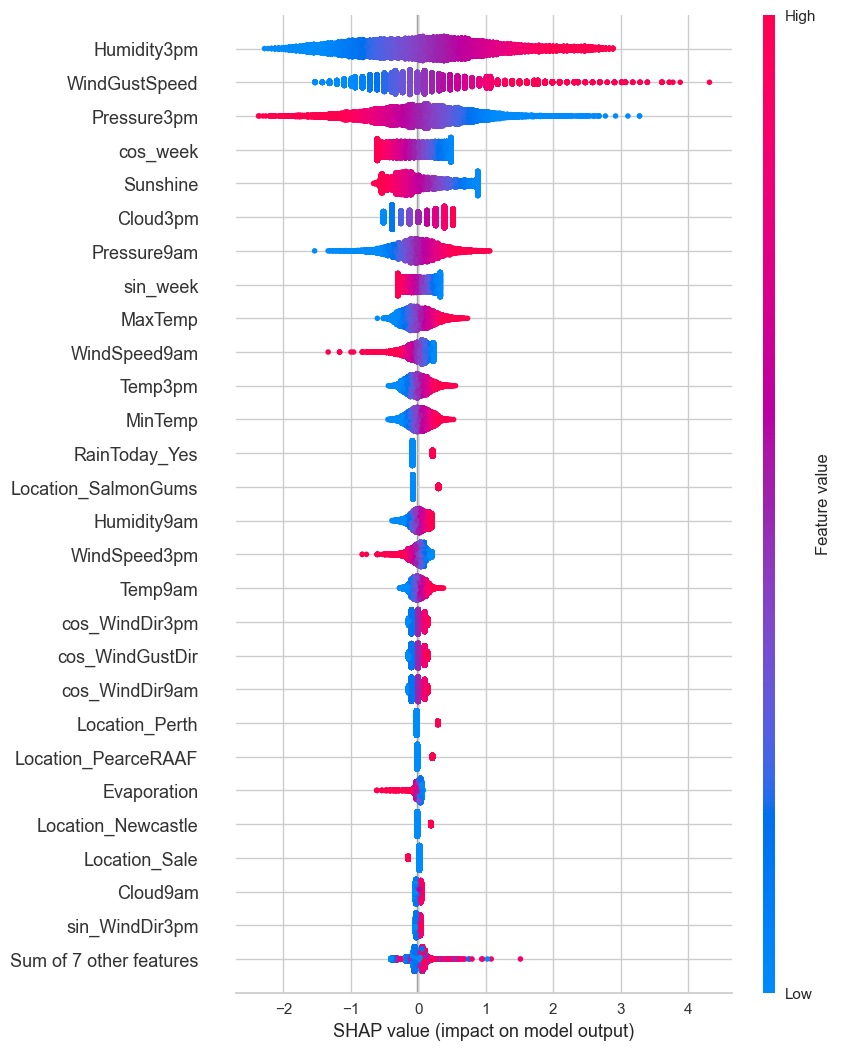

In [90]:
shap.plots.beeswarm(shap_values, max_display=28)

Tenemos una hipótesis de que ciertas variables las cuales fueron codificadas, no son facilmente interpretables por SHAP, ya que la variable en sí es el conjunto de todas sus variables codificadas, por ejemplo si tuviera la localidad la cual por onehotencoding no tiene una variable de 0 y 1, sino es el descarte de que no es el clima de todas las otras localidades, el SHAP no lo podría interpretar como una sola variable, sino el conjunto de todas las variables en 0, lo mismo con los senos y cosenos de diferentes variables.

También concluimos que la interpretación global tiene el problema de que no aplica para todos los datos, siendo que si interpretaramos dato por dato, cada uno tiene una interpretación shap diferente.

### AutoML

In [94]:
x_train_automl['Date'] = pd.to_datetime(x_train_automl['Date'])
x_test_automl['Date'] = pd.to_datetime(x_test_automl['Date'])
train_ml_compl = x_train_automl.copy()
test_ml_compl = x_test_automl.copy()
y_train_automl = y_train_automl.squeeze()
y_test_automl = y_test_automl.squeeze()
train_ml_compl['RainTomorrow'] = y_train_automl
test_ml_compl['RainTomorrow'] = y_test_automl

Se observa que aún agregando varios parámetros para un mejor AutoML, llega a las métricas superiores a las de nuestro modelo base implementado. 

In [95]:
exp_name = setup(data = train_ml_compl, test_data=test_ml_compl,  target = 'RainTomorrow')
add_metric('wrecall', 'Wrecall', calcular_wrecall_estimador,greater_is_better=True)
lr_sencillo = create_model('lr')


Se observa que en el caso de hacer un AutoML por default, las métricas del modelo son muy parecidas a las de el modelo base.

In [96]:
resultados = predict_model(lr_sencillo)  # No es necesario pasar `data`

----------
---------
-----------

### Red neuronal

In [97]:
class CustomMetric(tf.keras.metrics.Metric):
    def __init__(self, name='custom_metric', **kwargs):
        super(CustomMetric, self).__init__(name=name, **kwargs)
        self.true_positives_0 = self.add_weight(name="tp0", initializer="zeros")
        self.false_negatives_0 = self.add_weight(name="fn0", initializer="zeros")
        self.true_positives_1 = self.add_weight(name="tp1", initializer="zeros")
        self.false_negatives_1 = self.add_weight(name="fn1", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class indices
        y_pred = tf.cast(y_pred >= 0.5, tf.int32)  # Umbral en 0.5 para convertir probabilidades
        y_true = tf.cast(y_true, tf.int32)

        # Update metrics for class 0
        self.true_positives_0.assign_add(tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 0), tf.float32)))
        self.false_negatives_0.assign_add(tf.reduce_sum(tf.cast((y_true == 0) & (y_pred != 0), tf.float32)))

        # Update metrics for class 1
        self.true_positives_1.assign_add(tf.reduce_sum(tf.cast((y_true == 1) & (y_pred == 1), tf.float32)))
        self.false_negatives_1.assign_add(tf.reduce_sum(tf.cast((y_true == 1) & (y_pred != 1), tf.float32)))

    def result(self):
        # Calculate recall for class 0
        recall_0 = self.true_positives_0 / (self.true_positives_0 + self.false_negatives_0 + tf.keras.backend.epsilon())
        # Calculate recall for class 1
        recall_1 = self.true_positives_1 / (self.true_positives_1 + self.false_negatives_1 + tf.keras.backend.epsilon())
        # Calculate the custom metric
        custom_metric = 2 * (recall_0 * recall_1) / (recall_0 + recall_1 + tf.keras.backend.epsilon())
        return custom_metric

    def reset_states(self):
        # Reset metric state variables
        self.true_positives_0.assign(0)
        self.false_negatives_0.assign(0)
        self.true_positives_1.assign(0)
        self.false_negatives_1.assign(0)

In [98]:
class NeuralNetwork:
    def __init__(self, epochs=50, batch_size=16, learning_rate=0.01):
        #inicializo algunos parámetros como épocas, batch_size, learning rate
        #(no son necesarios)
        #se puede agregar la cantidad de capas, la cantidad de neuronas por capa (pensando en hacer una clase que pueda ser usada para cualquier caso)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self, input_shape, num_classes):
        # ejemplo con 2 capas ocultas de 64 neuronas y activación softmax (multiclase, recibe la cantidad de clases como input, además del input_shape)
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(16, activation='sigmoid',input_shape=(input_shape,)),#,kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(input_shape,)),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(8, activation='sigmoid'),#,kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            # tf.keras.layers.Dropout(0.1),
            # tf.keras.layers.Dense(8, activation='sigmoid'),
            # tf.keras.layers.Dense(32, activation='sigmoid'),#,kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            # tf.keras.layers.Dense(32, activation='relu'),#,kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            # tf.keras.layers.Dropout(0.05),
            # tf.keras.layers.Dense(8, activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            # tf.keras.layers.Dropout(0.05),
            # tf.keras.layers.Dense(16, activation='sigmoid'),
            # tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        #compilo el modelo con el optimizador Adam, la función de pérdida categorical_crossentropy y la métrica accuracy
        #totalmente optimizable e incluso pueden ser parámetros de la función build_model
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[CustomMetric()])
        
        self.model = model

    def train(self, X_train, y_train, X_valid, y_valid):
        # simplemente el fit del modelo. Devuelvo la evolución de la función de pérdida, ya que es interesante ver como varía a medida que aumentan las épocas!
        history=self.model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=self.epochs, batch_size=self.batch_size)
        return history.history['custom_metric'], history.history['val_custom_metric']

    def evaluate(self, X_test, y_test):
        ### evalúo en test
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"test accuracy: {accuracy:.4f}")

    def predict(self, X_new):
        ### predicciones
        predictions = self.model.predict(X_new)
        return predictions
    def plot_loss(self, train_loss, val_loss):
        ### ploteo de la evolución de la función de pérdida
        plt.figure(figsize=(8, 6))
        plt.plot(train_loss, label='Train Wrecall', marker='o')
        plt.plot(val_loss, label='Validation Wrecall', marker='o')
        plt.title('Evolución de la Wrecall', fontsize=14)
        plt.xlabel('Épocas', fontsize=12)
        plt.ylabel('Wrecall', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

Mejores hiperparámetros: {'learning_rate': 0.003, 'batch_size': 73, 'num_layers': 2, 'units_per_layer': 16 8, 'activation': 'sigmoid', 'optimizer': 'adam', dropout: 0.1} --> 0.7869

#### Métricas y entrenamiento de NN

In [99]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, sampling_strategy='minority')
X_res, y_res = sm.fit_resample(x_train_procesado_iterative, y_train_codif)
x_train_nn, x_valid_nn, y_train_nn, y_valid_nn = train_test_split(X_res, y_res, test_size=0.2)


In [100]:
nn = NeuralNetwork(epochs=100, batch_size=73, learning_rate=0.003)

nn.build_model(input_shape=x_train_nn.shape[1], num_classes=y_train_nn.shape[1])

# entreno el modelo
history=nn.train(x_train_nn, y_train_nn, x_valid_nn, y_valid_nn)

# evaluo metricas
nn.evaluate(x_test_procesado_iterative, y_test_codif)

Epoch 1/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - custom_metric: 0.5743 - loss: 0.6522 - val_custom_metric: 0.7813 - val_loss: 0.4728
Epoch 2/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - custom_metric: 0.7807 - loss: 0.4726 - val_custom_metric: 0.7941 - val_loss: 0.4433
Epoch 3/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - custom_metric: 0.7939 - loss: 0.4506 - val_custom_metric: 0.8021 - val_loss: 0.4310
Epoch 4/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - custom_metric: 0.7994 - loss: 0.4386 - val_custom_metric: 0.8039 - val_loss: 0.4221
Epoch 5/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - custom_metric: 0.7953 - loss: 0.4398 - val_custom_metric: 0.8054 - val_loss: 0.4186
Epoch 6/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - custom_metric: 0.8042 - loss: 0.4254 - val_custom_metric: 0.8055 - val_loss: 0.4151
Epoch 7/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - custom_metric: 0.8031 - loss: 0.4261 - val_custom_metric: 0.8097 - val_loss: 0.4058
Epoch 8/100
409

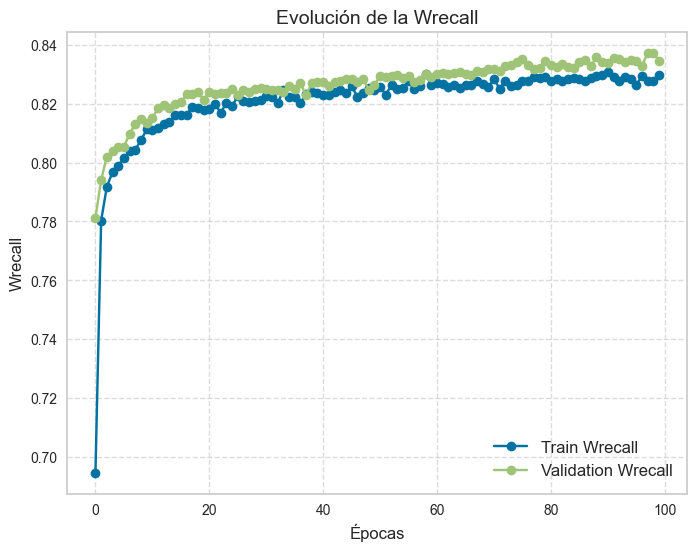

In [101]:
nn.plot_loss(history[0], history[1])

In [102]:
class NeuralNetworkWithCustomMetric(NeuralNetwork):
    def build_model(self, input_shape, num_classes):
        # Construcción del modelo con capas ajustables
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(input_shape,)),
            tf.keras.layers.Dense(32, activation='sigmoid'),
            tf.keras.layers.Dense(64, activation='sigmoid'),
            tf.keras.layers.Dense(32, activation='sigmoid'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[CustomMetric()])
        
        self.model = model

#### Optimización de NN

In [ ]:
def objective_with_custom_metric(trial):
    # Hiperparámetros sugeridos por Optuna
    learning_rate = trial.suggest_categorical('learning_rate', [0.001,0.01,0.05])
    batch_size = trial.suggest_int('batch_size', 64, 128)
    num_layers = trial.suggest_int('num_layers', 2, 4)
    units_per_layer = trial.suggest_categorical('units_per_layer',[32, 64, 128])
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam'])
    dropout = trial.suggest_categorical('dropout', [0.001, 0.01, 0.05])
    l2_reg = trial.suggest_categorical('l2_reg', [0.001, 0.01])

    # Crear el modelo con los hiperparámetros
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(x_train_nn.shape[1],)))
    
    for _ in range(num_layers):
        model.add(tf.keras.layers.Dense(units_per_layer, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    optimizer = {
        'adam': tf.keras.optimizers.Adam(learning_rate=learning_rate),
    }[optimizer_name]

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[CustomMetric()])
    
    # Entrenar el modelo
    history = model.fit(
        x_train_nn, y_train_nn,
        validation_data=(x_valid_nn, y_valid_nn),
        epochs=20,
        batch_size=batch_size,
        verbose=0
    )
    
    # Obtener la métrica personalizada en el conjunto de validación
    val_custom_metric = history.history['val_custom_metric'][-1]
    return val_custom_metric

In [ ]:
# # Crear el estudio de Optuna
# study = optuna.create_study(direction='maximize')  # Maximizar la métrica personalizada
# study.optimize(objective_with_custom_metric, n_trials=200)

# # Mostrar los mejores hiperparámetros
# print("Mejores hiperparámetros:", study.best_params)

Mejores hiperparámetros: {'learning_rate': 0.01, 'batch_size': 73, 'num_layers': 3, 'units_per_layer': 128, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.05, 'l2_reg': 0.001}

In [ ]:
# best_params = study.best_params

# # Configurar la red neuronal con los mejores hiperparámetros
# nn_optimized = NeuralNetworkWithCustomMetric(
#     epochs=100,
#     batch_size=best_params['batch_size'],
#     learning_rate=best_params['learning_rate']
# )

# nn_optimized.build_model(input_shape=x_train_nn.shape[1], num_classes=1)

# # Entrenar con los mejores parámetros
# history = nn_optimized.train(x_train_nn, y_train_nn, x_valid_nn, y_valid_nn)

# # Evaluar en el conjunto de prueba
# nn_optimized.evaluate(x_test_procesado_iterative, y_test_codif)

# nn.plot_loss(history[0], history[1])

Con las redes neuronales conseguimos métricas parecidas a nuestro modelos optimizado con optuna, un poco mejores en teoría

#### Explicabilidad del modelo

##### Interpretación local con SHAP

In [103]:
explainer = shap.DeepExplainer(nn.model, x_train_nn[:100])

In [ ]:
instancia = x_test_procesado_iterative.iloc[0]
instancia = instancia.values.reshape(1,-1)
shap_values = explainer.shap_values(instancia)
nuevo_shap = shap_values[0].T
expected_value = explainer.expected_value[0].numpy()

In [ ]:
shap.initjs()
shap.force_plot(expected_value, nuevo_shap[0], instancia, feature_names=x_train_nn.columns)

In [ ]:
shap.plots.waterfall(shap.Explanation(
    values=nuevo_shap[0],
    base_values=expected_value,
    data=instancia[0],
    feature_names=x_train_nn.columns
),max_display=35)

##### Interpretación global con SHAP

In [ ]:
nuevo_shap_global = explainer.shap_values(x_test_procesado_iterative.values)

In [ ]:
columnas = x_train_nn.columns

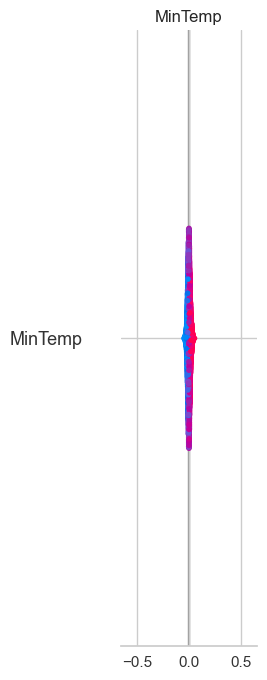

In [ ]:
# shap.summary_plot(nuevo_shap_global, x_test_procesado_iterative.values, feature_names=columnas)
shap.summary_plot(nuevo_shap_global, x_test_procesado_iterative, plot_type="bar",feature_names=columnas)

### Comparación de modelos.

In [108]:
y_pred_nn = nn.predict(x_test_procesado_iterative)
y_pred_nn = (y_pred_nn>0.38)*1

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step


In [109]:
metricas_opt = calcular_metricas_modelo(y_test_codif, y_pred_opt_optuna, 'Modelo Optimizado con Optuna')
metricas_base = calcular_metricas_modelo(y_test_codif, y_pred_avg, 'Modelo Base')
resultados = predict_model(lr_sencillo)
metricas_relog = calcular_metricas_modelo(y_test_codif, y_pred_relog, 'Relog balanceada')
metricas_relog_desba = calcular_metricas_modelo(y_test_codif, y_pred_relog_desba, 'Relog desbalanceada')
metricas_nn = calcular_metricas_modelo(y_test_codif, y_pred_nn, 'Red neuronal')

display(metricas_relog,metricas_relog_desba,metricas_opt,metricas_base,metricas_nn)

Accuracy  Precision    Recall        F1  \
Relog balanceada - Llueve     0.792865   0.473174  0.752269  0.580939   
Relog balanceada - No Llueve  0.792865   0.932123  0.802440  0.862434   

                              Matthews   Jaccard   Wrecall  
Relog balanceada - Llueve     0.474154  0.409383  0.776545  
Relog balanceada - No Llueve  0.474154  0.409383  0.776545

Accuracy  Precision    Recall        F1  \
Relog desbalanceada - Llueve     0.861101   0.706612  0.465517  0.561269   
Relog desbalanceada - No Llueve  0.861101   0.883320  0.954409  0.917490   

                                 Matthews   Jaccard   Wrecall  
Relog desbalanceada - Llueve     0.497723  0.390114  0.625799  
Relog desbalanceada - No Llueve  0.497723  0.390114  0.625799

Accuracy  Precision    Recall  \
Modelo Optimizado con Optuna - Llueve     0.782646   0.458537  0.767695   
Modelo Optimizado con Optuna - No Llueve  0.782646   0.934843  0.786173   

                                                F1  Matthews   Jaccard  \
Modelo Optimizado con Optuna - Llueve     0.574143  0.466777  0.402665   
Modelo Optimizado con Optuna - No Llueve  0.854087  0.466777  0.402665   

                                           Wrecall  
Modelo Optimizado con Optuna - Llueve     0.776824  
Modelo Optimizado con Optuna - No Llueve  0.776824

Accuracy  Precision    Recall        F1  Matthews  \
Modelo Base - Llueve     0.701074   0.357012  0.706897  0.474421  0.329542   
Modelo Base - No Llueve  0.701074   0.910078  0.699700  0.791142  0.329542   

                          Jaccard  Wrecall  
Modelo Base - Llueve     0.310978  0.70328  
Modelo Base - No Llueve  0.310978  0.70328

Accuracy  Precision    Recall        F1  Matthews  \
Red neuronal - Llueve     0.770696   0.443996  0.798548  0.570687  0.465708   
Red neuronal - No Llueve  0.770696   0.941456  0.764127  0.843573  0.465708   

                           Jaccard   Wrecall  
Red neuronal - Llueve     0.399274  0.780958  
Red neuronal - No Llueve  0.399274  0.780958